In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, chi2, RFECV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
import time
from sklearn.metrics import classification_report, confusion_matrix
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

Patient_ID  Family_Case_ID  Severity               Name  Birthday_year  \
0           1            4696         3   Miss Linda Betty            NaN   
1           2           21436         1  Ms. Ramona Elvira         1966.0   
2           3            7273         3   Mr. Mario Vernon         1982.0   
3           4            8226         3     Mr. Hector Joe         1997.0   
4           5           19689         3   Ms. Jennie Debra         1994.0   

   Parents or siblings infected  Wife/Husband or children infected  \
0                             0                                  0   
1                             0                                  1   
2                             0                                  0   
3                             0                                  0   
4                             0                                  0   

   Medical_Expenses_Family Medical_Tent         City  Deceased  
0                      225          NaN     Santa Fe         1  
1                     1663          NaN  Albuquerque         0  
2                      221          NaN     Santa Fe         1  
3                      220          NaN     Santa Fe         1  
4                      222          NaN     Santa Fe         0

In [4]:
train.shape

(900, 11)

In [5]:
train.columns

Index(['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City', 'Deceased'],
      dtype='object')

In [6]:
train.dtypes

Patient_ID                             int64
Family_Case_ID                         int64
Severity                               int64
Name                                  object
Birthday_year                        float64
Parents or siblings infected           int64
Wife/Husband or children infected      int64
Medical_Expenses_Family                int64
Medical_Tent                          object
City                                  object
Deceased                               int64
dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         900 non-null    int64  
 1   Family_Case_ID                     900 non-null    int64  
 2   Severity                           900 non-null    int64  
 3   Name                               900 non-null    object 
 4   Birthday_year                      723 non-null    float64
 5   Parents or siblings infected       900 non-null    int64  
 6   Wife/Husband or children infected  900 non-null    int64  
 7   Medical_Expenses_Family            900 non-null    int64  
 8   Medical_Tent                       198 non-null    object 
 9   City                               898 non-null    object 
 10  Deceased                           900 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [8]:
train.describe()

Patient_ID  Family_Case_ID    Severity  Birthday_year  \
count  900.000000      900.000000  900.000000     723.000000   
mean   450.500000    14305.827778    2.313333    1990.266943   
std    259.951919    25418.153900    0.834223      14.523335   
min      1.000000      345.000000    1.000000    1940.000000   
25%    225.750000     8203.000000    2.000000    1982.000000   
50%    450.500000    13593.500000    3.000000    1992.000000   
75%    675.250000    18906.500000    3.000000    1999.500000   
max    900.000000   742836.000000    3.000000    2019.000000   

       Parents or siblings infected  Wife/Husband or children infected  \
count                    900.000000                         900.000000   
mean                       0.380000                           0.521111   
std                        0.803247                           1.098385   
min                        0.000000                           0.000000   
25%                        0.000000                           0.000000   
50%                        0.000000                           0.000000   
75%                        0.000000                           1.000000   
max                        6.000000                           8.000000   

       Medical_Expenses_Family    Deceased  
count               900.000000  900.000000  
mean                895.743333    0.614444  
std                1385.829926    0.486997  
min                   0.000000    0.000000  
25%                 221.000000    0.000000  
50%                 405.000000    1.000000  
75%                 861.250000    1.000000  
max               14345.000000    1.000000

In [9]:
for col in ['Severity','Birthday_year','Medical_Tent','City']:
    print(col + ':', train[col].unique())

Severity: [3 1 2]
Birthday_year: [  nan 1966. 1982. 1997. 1994. 1984. 1989. 2000. 2009. 1999. 1991. 2019.
 1964. 2017. 1987. 2011. 1998. 2002. 1992. 1981. 1990. 1978. 2001. 1958.
 1996. 2004. 1962. 1970. 1985. 1965. 2018. 1995. 1956. 2003. 1986. 1971.
 1983. 2005. 1975. 1950. 2016. 2013. 1980. 1979. 2014. 1988. 1993. 1968.
 2006. 1973. 2007. 2012. 1946. 1974. 1972. 2008. 1976. 1961. 1957. 1960.
 1959. 2015. 2010. 1969. 1949. 1955. 1977. 1963. 1954. 1967. 1940.]
Medical_Tent: [nan 'F' 'B' 'A' 'E' 'C' 'D' 'G' 'T']
City: ['Santa Fe' 'Albuquerque' 'Taos' nan]


In [10]:
train.duplicated().any()

False

In [11]:
train.groupby(['Deceased']).count()

Patient_ID  Family_Case_ID  Severity  Name  Birthday_year  \
Deceased                                                              
0                347             347       347   347            295   
1                553             553       553   553            428   

          Parents or siblings infected  Wife/Husband or children infected  \
Deceased                                                                    
0                                  347                                347   
1                                  553                                553   

          Medical_Expenses_Family  Medical_Tent  City  
Deceased                                               
0                             347           131   345  
1                             553            67   553

In [12]:
data = train.drop(['Patient_ID','Deceased'],1)
target = train['Deceased']

Only three columns: Severity, Medical_Tent, and City, are categorical variables, and only Name, Medical_Tent, and City are non-numerical.

The values for all variables seem to be within the expected range.

There are null values in the columns: Birthday_year, Medical_Tent, and City.

There are no duplicated lines.

The target classes are not balanced.

## Preprocessing

### Add New Variables

`Infected_per_Family` Sum of Parents or sibilings infected and Wife/Husband or children infected<br>
`Maritial_state` 1 if it is married 0 otherwise <br>
`Gender` 1 if it is female 0 otherwise <br>
`Is_young: `0 if the age is lower than 60, 1 otherwise<br>

In [13]:
data['Infected_per_Family'] = data['Parents or siblings infected'] + data['Wife/Husband or children infected']
data['Marital_Status'] = 0
data['Gender'] = 0
data['Title'] = 0
# 2020-60 = 1960
data['Is_young'] = 0
for i in data.index:
    if data['Birthday_year'][i]<=1960:
        data['Is_young'][i] = 0
    elif data['Birthday_year'][i]>1960:
        data['Is_young'][i] = 1
    else:
        data['Is_young'][i] = None

In [14]:
data['Title_Miss'] = data['Name']
data['Title_Ms'] = data['Name']
data['Title_Mrs'] = data['Name']
data['Title_Mr'] = data['Name']
data['Title_Master'] = data['Name']

for i in data.index:
    if data['Name'][i].startswith('Miss'):
        data['Marital_Status'][i] = 0
        data['Gender'][i] = 1
        data['Title_Miss'][i] = 1
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Ms.'):
        data['Marital_Status'][i] = None
        data['Gender'][i] = 1
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 1
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Mrs.'):
        data['Marital_Status'][i] = 1
        data['Gender'][i] = 1
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 1
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Mr.'):
        data['Marital_Status'][i] = 1
        data['Gender'][i] = 0
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 1
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Master'):
        data['Marital_Status'][i] = 0
        data['Gender'][i] = 0
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 1

In [15]:
data[data['Marital_Status'].isnull()].shape

(209, 19)

### Encoding Categorical Values

Because the label encoder does not work with null values in the data frame, but we need the variables to be encoded to use a KNNImputer, first we are replacing the all null value in the City column with a dummy, absurd variable, run the encoder, and then turn them back to nulls.

In [16]:
data['City'].mode()[0]

'Santa Fe'

In [17]:
data['City'] = data['City'].fillna(data['City'].mode()[0])

In [18]:
data['City_SantaFe'] = data['City']
data['City_Albuquerque'] = data['City']
data['City_Taos'] = data['City']

for i in data['City'].index:
    if data['City'][i] == 'Santa Fe':
        data['City_SantaFe'][i] = 1
        data['City_Albuquerque'][i] = 0
        data['City_Taos'][i] = 0
    elif data['City'][i] == 'Albuquerque':
        data['City_SantaFe'][i] = 0
        data['City_Albuquerque'][i] = 1
        data['City_Taos'][i] = 0
    elif data['City'][i] == 'Taos':
        data['City_SantaFe'][i] = 0
        data['City_Albuquerque'][i] = 0
        data['City_Taos'][i] = 1

In [19]:
data.head()

Family_Case_ID  Severity               Name  Birthday_year  \
0            4696         3   Miss Linda Betty            NaN   
1           21436         1  Ms. Ramona Elvira         1966.0   
2            7273         3   Mr. Mario Vernon         1982.0   
3            8226         3     Mr. Hector Joe         1997.0   
4           19689         3   Ms. Jennie Debra         1994.0   

   Parents or siblings infected  Wife/Husband or children infected  \
0                             0                                  0   
1                             0                                  1   
2                             0                                  0   
3                             0                                  0   
4                             0                                  0   

   Medical_Expenses_Family Medical_Tent         City  Infected_per_Family  \
0                      225          NaN     Santa Fe                    0   
1                     1663          NaN  Albuquerque                    1   
2                      221          NaN     Santa Fe                    0   
3                      220          NaN     Santa Fe                    0   
4                      222          NaN     Santa Fe                    0   

   ...  Title  Is_young  Title_Miss  Title_Ms Title_Mrs Title_Mr Title_Master  \
0  ...      0       NaN           1         0         0        0            0   
1  ...      0       1.0           0         1         0        0            0   
2  ...      0       1.0           0         0         0        1            0   
3  ...      0       1.0           0         0         0        1            0   
4  ...      0       1.0           0         1         0        0            0   

  City_SantaFe City_Albuquerque City_Taos  
0            1                0         0  
1            0                1         0  
2            1                0         0  
3            1                0         0  
4            1                0         0  

[5 rows x 22 columns]

### Null Values

There were null values in the columns Birthday_year, City and Medical_Tent.

- **Birthday_year:** 117 (13% of the data)
- **Medical_Tent:** 702 (78% of the data)
- **City:** 2

And the new column Marital_Status also has null values:

- **Marital_Status:** 209 (23% of the data)

In [20]:
data[data.isnull().any(axis=1)]

Family_Case_ID  Severity                 Name  Birthday_year  \
0              4696         3     Miss Linda Betty            NaN   
1             21436         1    Ms. Ramona Elvira         1966.0   
2              7273         3     Mr. Mario Vernon         1982.0   
3              8226         3       Mr. Hector Joe         1997.0   
4             19689         3     Ms. Jennie Debra         1994.0   
..              ...       ...                  ...            ...   
895            6253         3     Ms. Linda Wilcox         1998.0   
896            6483         3     Mr. Haiden Vance         2006.0   
897             981         3     Miss Anaiya Love         1990.0   
898           16418         2  Mr. Robert Williams         1994.0   
899            3782         3    Ms. Marjorie Hays         2002.0   

     Parents or siblings infected  Wife/Husband or children infected  \
0                               0                                  0   
1                               0                                  1   
2                               0                                  0   
3                               0                                  0   
4                               0                                  0   
..                            ...                                ...   
895                             1                                  1   
896                             0                                  0   
897                             0                                  0   
898                             1                                  1   
899                             0                                  0   

     Medical_Expenses_Family Medical_Tent         City  Infected_per_Family  \
0                        225          NaN     Santa Fe                    0   
1                       1663          NaN  Albuquerque                    1   
2                        221          NaN     Santa Fe                    0   
3                        220          NaN     Santa Fe                    0   
4                        222          NaN     Santa Fe                    0   
..                       ...          ...          ...                  ...   
895                      344          NaN     Santa Fe                    2   
896                      258          NaN     Santa Fe                    0   
897                      214          NaN         Taos                    0   
898                      812          NaN     Santa Fe                    2   
899                      202            C  Albuquerque                    0   

     ...  Title  Is_young  Title_Miss  Title_Ms Title_Mrs Title_Mr  \
0    ...      0       NaN           1         0         0        0   
1    ...      0       1.0           0         1         0        0   
2    ...      0       1.0           0         0         0        1   
3    ...      0       1.0           0         0         0        1   
4    ...      0       1.0           0         1         0        0   
..   ...    ...       ...         ...       ...       ...      ...   
895  ...      0       1.0           0         1         0        0   
896  ...      0       1.0           0         0         0        1   
897  ...      0       1.0           1         0         0        0   
898  ...      0       1.0           0         0         0        1   
899  ...      0       1.0           0         1         0        0   

    Title_Master City_SantaFe City_Albuquerque City_Taos  
0              0            1                0         0  
1              0            0                1         0  
2              0            1                0         0  
3              0            1                0         0  
4              0            1                0         0  
..           ...          ...              ...       ...  
895            0            1                0         0  
896            0            1                0   

In [21]:
data[data.isnull().any(axis=1)].shape

(796, 22)

In [22]:
null_ind = data[data.isnull().any(axis=1)].index

In [23]:
len(null_ind)

796

There are 78% of the data missing on the Medical_Tent column, this is too much therefore this column will be dropped.

Since there are only two null values in the column City, they can simply be replaced using the mode.

In the birthday year column values can be replaced with either the median (since it's less sensible to outliers), or KNNImputer, and for the Is_young columns the mode or KNNImputer can be used, if Birthday_year is not available to compute it.

In [24]:
def null_values(data, method='knn', k=1): 
    # drop the Medical_Tent column 
    data = data.drop(['Medical_Tent'],1)
    
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=k)
        imputer.fit(data)
        data = pd.DataFrame(data=imputer.transform(data),columns=data.columns,index=data.index)
        
    if method == 'stat':
        cols = []
        for col in ['Birthday_year','Is_young','Marital_Status']:
            if col in data.columns:
                cols.append(col)
                
        if 'Birthday_year' in cols:
            data['Birthday_year'] = data['Birthday_year'].fillna(round(data['Birthday_year'].median()))
            if 'Is_young' in cols:
                for i in data['Is_young'].isna().index:
                    if data['Birthday_year'][i]<=1960:
                        data['Is_young'][i] = 0
                    elif data['Birthday_year'][i]>1960:
                        data['Is_young'][i] = 1
        elif 'Is_young' in cols:
            data['Is_young'] = data['Is_young'].fillna(float(data['Is_young'].mode()))
            
        if 'Marital_Status' in cols:
            data['Marital_Status'] = data['Marital_Status'].fillna(float(data['Marital_Status'].mode()))
                
    return data

In [25]:
null_values(data.drop(['Name','City'],1),method='stat').iloc[null_ind,:]

Family_Case_ID  Severity  Birthday_year  Parents or siblings infected  \
0              4696         3         1992.0                             0   
1             21436         1         1966.0                             0   
2              7273         3         1982.0                             0   
3              8226         3         1997.0                             0   
4             19689         3         1994.0                             0   
..              ...       ...            ...                           ...   
895            6253         3         1998.0                             1   
896            6483         3         2006.0                             0   
897             981         3         1990.0                             0   
898           16418         2         1994.0                             1   
899            3782         3         2002.0                             0   

     Wife/Husband or children infected  Medical_Expenses_Family  \
0                                    0                      225   
1                                    1                     1663   
2                                    0                      221   
3                                    0                      220   
4                                    0                      222   
..                                 ...                      ...   
895                                  1                      344   
896                                  0                      258   
897                                  0                      214   
898                                  1                      812   
899                                  0                      202   

     Infected_per_Family  Marital_Status  Gender  Title  Is_young Title_Miss  \
0                      0             0.0       1      0       1.0          1   
1                      1             1.0       1      0       1.0          0   
2                      0             1.0       0      0       1.0          0   
3                      0             1.0       0      0       1.0          0   
4                      0             1.0       1      0       1.0          0   
..                   ...             ...     ...    ...       ...        ...   
895                    2             1.0       1      0       1.0          0   
896                    0             1.0       0      0       1.0          0   
897                    0             0.0       1      0       1.0          1   
898                    2             1.0       0      0       1.0          0   
899                    0             1.0       1      0       1.0          0   

    Title_Ms Title_Mrs Title_Mr Title_Master City_SantaFe City_Albuquerque  \
0          0         0        0            0            1                0   
1          1         0        0            0            0                1   
2          0         0        1            0            1                0   
3          0         0        1            0            1                0   
4          1         0        0            0            1                0   
..       ...       ...      ...          ...          ...              ...   
895        1         0        0            0            1                0   
896        0         0        1            0            1                0   
897        0         0        0            0            0                0   
898        0         0        1            0            1                0   
899        1         0        0            0            0                1   

    City_Taos  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
895         0  
896         0  
897         1  
898         0  
899         0  

[796 rows x 19 columns]

### Outliers

Since all categorical variables have values within the expected range, we're going to check only the continuous variables for outliers.

In [26]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City',
       'Infected_per_Family', 'Marital_Status', 'Gender', 'Title', 'Is_young',
       'Title_Miss', 'Title_Ms', 'Title_Mrs', 'Title_Mr', 'Title_Master',
       'City_SantaFe', 'City_Albuquerque', 'City_Taos'],
      dtype='object')

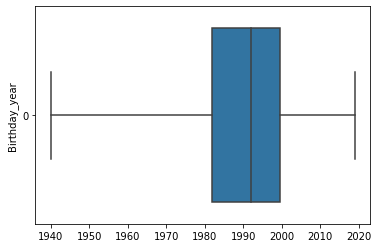

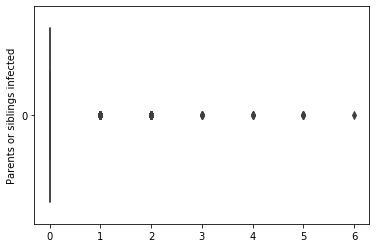

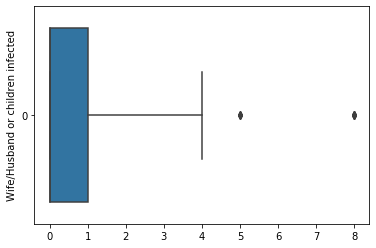

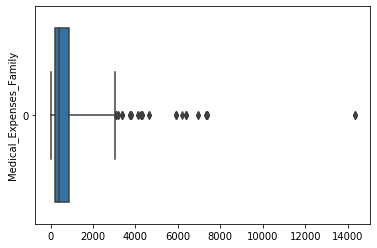

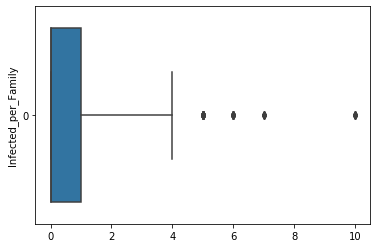

In [27]:
col = ['Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']

for c in col:
    sns.boxplot(data=data[c],orient='h',whis=3.5)
    plt.ylabel(c)
    plt.show()

In [28]:
def outliers(data, target, std=3, remove=False, pr=False):
    cols = []
    for col in ['Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']:
        if col in data.columns:
            cols.append(col)
    
    ind = []
    ind_to_remove = []
    
    if len(cols)>0:
        out = data[cols]
        out = pd.DataFrame(data=StandardScaler().fit_transform(out),index=out.index,columns=out.columns)

        for col in out.columns:
            ind_col = list(out[(out[col]<-std)|(out[col]>std)].index)
            ind += ind_col

        for i in ind:
            if i not in ind_to_remove:
                ind_to_remove.append(i)
            
    if pr == True:
        print(len(ind_to_remove))
    
    if remove == True:
        for i in ind_to_remove:
            data = data.drop(i,0)
            target = target.drop(i,0)
        
        return data, target

In [29]:
outliers(data, target, pr=True)

66


This is around 7% of the data, and so an acceptable number of outliers to remove.

These outliers can be ignored or removed.

### Oversampling

Since the target variable is unbalanced, a hypothesis is to balance the dataset through oversampling. Undersampling was not considered because there's not much data to begin with.

In [30]:
def oversample(data, target):
    X = pd.concat([data, target], axis=1)      

    false = X[X.Deceased==0]
    true = X[X.Deceased==1]    

    false_upsampled = resample(false,
                               replace=True, # sample with replacement
                               n_samples=len(medium), # match number in majority class
                               random_state=27) # reproducible results        

    upsampled = pd.concat([false_upsampled, true])

    data = upsampled.drop(['Deceased'],1)
    target = upsampled['Deceased']   

    return data, target

## Tuning Hyperparameters

In [31]:
def avg_score(model_, method='knn', k=1, remove=False, std=3, oversampling=False, scaler=MinMaxScaler(), grid_search=False, parameters=None, features=False):
    # apply kfold
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    
    data__ = data.drop(['Name','City','Title'],1)
    
    """cat_col = []
    num_col = []

    for col in data__.columns:
        if col in ['Severity','City','Marital_Status','Gender','Title','Is_young']:
            cat_col.append(col)
        elif col in ['Family_Case_ID','Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']:
            num_col.append(col)
    
    anova = pd.Series(data=0,index=num_col)
    chi = pd.Series(data=0,index=cat_col)"""
    
    for train_index, test_index in kf.split(data__,target):
        model = deepcopy(model_)
        
        # get the indexes of the observations assigned for each partition
        X_train, X_test = data__.iloc[train_index], data__.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # deal with the null values
        X_train = null_values(X_train, method=method, k=k)
        X_test = null_values(X_test, method=method,k=k)
            
        # deal with outliers
        if remove == True:
            X_train, y_train = outliers(X_train, y_train, std=std, remove=remove)
        
        # oversample the minority class
        if oversampling == True:
            X_train, y_train = oversample(X_train, y_train)
            
        """if features == True:
            data_cat = X_train[cat_col]
            data_num = X_train[num_col]
            
            anova_ = pd.Series(data=f_classif(data_num,y_train)[0],index=data_num.columns)
            chi_ = pd.Series(data=chi2(data_cat,y_train)[0],index=data_cat.columns)
            
            anova += anova_
            chi += chi_"""
            
        # scale the data
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # start counting time
        begin = time.perf_counter()
        
        # find the best features
        if features == True:
            rfe = RFECV(estimator = model,n_jobs=-1,scoring='accuracy')
            X_train = rfe.fit_transform(X_train,y_train)
            X_test = rfe.transform(X_test)
            print(rfe.ranking_)
            print(X_train.shape)
        
        # find the best hyperparameters
        if grid_search == True:
            clf = RandomizedSearchCV(model,parameters,n_jobs=-1,scoring='accuracy',random_state=0)
            clf.fit(X_train,y_train)
            model = clf.best_estimator_
            print(clf.best_params_)
            
        # fit the model to the data
        model.fit(X_train, y_train)
        
        # finish counting time
        end = time.perf_counter()
        
        # predictions
        Y_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        # check the mean f1-score for the train
        value_train = model.score(X_train,y_train)
        
        # check the mean f1-score for the test
        value_test = model.score(X_test,y_test)
        
        # print a classification report and confusion matrix
        print(classification_report(y_true=y_test,y_pred=y_pred))
        print(confusion_matrix(y_true=y_test,y_pred=y_pred))
        
        # append the scores, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        #n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    #avg_iter = round(np.mean(n_iter),1)
    #std_iter = round(np.std(n_iter),1)
    
    """if features == True:
        anova = anova.sort_values(ascending=False)
        chi = chi.sort_values(ascending=False)
        
        print(anova)
        print(chi)"""
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)#, str(avg_iter) + '+/-' + str(std_iter)

In [32]:
def show_results(df, models, method = 'knn', k = 1, remove = False, std = 3, oversampling = False, scaler = MinMaxScaler(), parameters = None,features=False):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for model in models:
        parameter_space = None
        if parameters != None:
            parameter_space = parameters[models.index(model)]
            
        if parameter_space == None:
            grid_search = False
        else:
            grid_search = True
                
        print('----------------------------------')
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(model, method = method, k = k, remove = remove, std = std, oversampling = oversampling, grid_search = grid_search, scaler = scaler, parameters = parameter_space, features = features)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test#, avg_iter
        count+=1

    return df

In [33]:
model_simple = MLPClassifier(hidden_layer_sizes=(1,),max_iter=1000,random_state=0)
model_medium = MLPClassifier(hidden_layer_sizes=(50,50),max_iter=1000,random_state=0)
model_complex = MLPClassifier(hidden_layer_sizes=(100,100,100),max_iter=1000,random_state=0)

In [34]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['Simple','Medium','Complex'])
show_results(df,[model_simple,model_medium,model_complex])

----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        69
           1       0.80      0.85      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[45 24]
 [17 94]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
w

Time         Train          Test     Iterations
Simple   2.776+/-0.32   0.806+/-0.0  0.788+/-0.01    991.6+/-9.9
Medium   8.368+/-1.45  0.881+/-0.02  0.801+/-0.03  615.2+/-115.4
Complex  7.904+/-2.11  0.883+/-0.01  0.803+/-0.02   221.6+/-31.0

Performs better with a medium or complex network.

In [35]:
model_relu = MLPClassifier(activation='relu',max_iter=1000,random_state=0)
model_logistic = MLPClassifier(activation='logistic',max_iter=1000,random_state=0)
model_tanh = MLPClassifier(activation='tanh',max_iter=1000,random_state=0)
model_identity = MLPClassifier(activation='identity',max_iter=1000,random_state=0)

In [36]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['relu','logistic','tanh','identity'])
show_results(df,[model_relu,model_logistic,model_tanh,model_identity])

----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        69
           1       0.77      0.85      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[41 28]
 [17 94]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1       0.83      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.81      0.82       180
w

Time         Train          Test     Iterations
relu      9.157+/-1.65  0.862+/-0.01  0.808+/-0.03  841.4+/-125.1
logistic   2.11+/-0.28   0.801+/-0.0  0.784+/-0.03   233.0+/-15.7
tanh      3.987+/-3.08  0.824+/-0.02  0.782+/-0.01  383.2+/-297.5
identity  0.697+/-0.11   0.805+/-0.0  0.782+/-0.02   101.0+/-11.1

Performs better with activation function relu.

In [37]:
model_lr_big = MLPClassifier(solver='sgd',learning_rate_init=0.5,max_iter=1000,random_state=0)
model_lr_medium = MLPClassifier(solver='sgd',learning_rate_init=0.001,max_iter=1000,random_state=0)
model_lr_small = MLPClassifier(solver='sgd',learning_rate_init=0.000001,max_iter=1000,random_state=0)

In [38]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['big','medium','small'])
show_results(df,[model_lr_big,model_lr_medium,model_lr_small])

----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80      0.80       180

[[49 20]
 [16 95]]
              precision    recall  f1-score   support

           0       0.81      0.51      0.62        69
           1       0.75      0.93      0.83       111

    accuracy                           0.77       180
   macro avg       0.78      0.72      0.73       180
weighted avg       0.78      0.77      0.75       180

[[ 35  34]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       1

Time         Train          Test    Iterations
big     2.454+/-0.69  0.855+/-0.02  0.803+/-0.02  127.8+/-34.3
medium  3.704+/-0.58   0.789+/-0.0  0.782+/-0.02  280.8+/-16.0
small   0.145+/-0.01  0.424+/-0.04  0.429+/-0.06    12.0+/-0.0

Performs better with a big learning rate.

In [39]:
model_lr_big_inv = MLPClassifier(solver='sgd',learning_rate_init=0.5,learning_rate='invscaling',max_iter=1000,random_state=0)
model_lr_medium_inv = MLPClassifier(solver='sgd',learning_rate_init=0.001,learning_rate='invscaling',max_iter=1000,random_state=0)
model_lr_big_adap = MLPClassifier(solver='sgd',learning_rate_init=0.5,learning_rate='adaptive',max_iter=1000,random_state=0)
model_lr_medium_adap = MLPClassifier(solver='sgd',learning_rate_init=0.001,learning_rate='adaptive',max_iter=1000,random_state=0)

In [40]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['big_inv','medium_inv','big_adap','medium_adap'])
show_results(df,[model_lr_big_inv,model_lr_medium_inv,model_lr_big_adap,model_lr_medium_adap])

----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 91]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
w

Time         Train          Test    Iterations
big_inv      0.877+/-0.46  0.802+/-0.01  0.784+/-0.01   72.6+/-33.8
medium_inv   0.277+/-0.01  0.577+/-0.02   0.58+/-0.04    27.0+/-1.1
big_adap     4.052+/-0.63  0.877+/-0.02  0.803+/-0.03  378.6+/-50.7
medium_adap  6.096+/-3.29   0.789+/-0.0  0.782+/-0.02  336.0+/-15.9

With an adaptive learning rate the model performs better.

In [41]:
model_lr_big = MLPClassifier(solver='adam',learning_rate_init=0.5,max_iter=1000,random_state=0)
model_lr_medium = MLPClassifier(solver='adam',learning_rate_init=0.001,max_iter=1000,random_state=0)
model_lr_small = MLPClassifier(solver='adam',learning_rate_init=0.000001,max_iter=1000,random_state=0)

In [42]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['big','medium','small'])
show_results(df,[model_lr_big,model_lr_medium,model_lr_small])

----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.59      0.69        69
           1       0.79      0.93      0.85       111

    accuracy                           0.80       180
   macro avg       0.81      0.76      0.77       180
weighted avg       0.81      0.80      0.79       180

[[ 41  28]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.77      0.54      0.63        69
           1       0.76      0.90      0.82       111

    accuracy                           0.76       180
   macro avg       0.76      0.72      0.73       180
weighted avg       0.76      0.76      0.75       180

[[ 37  32]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        69
           1       0.79      0.90      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77    

Time         Train          Test     Iterations
big       0.441+/-0.1  0.817+/-0.01  0.798+/-0.02    48.0+/-12.3
medium  10.501+/-1.42  0.862+/-0.01  0.808+/-0.03  841.4+/-125.1
small    0.156+/-0.01  0.426+/-0.04  0.429+/-0.06     12.0+/-0.0

medium learning rate has the best performance.

In [43]:
model_sgd = MLPClassifier(solver='sgd',learning_rate_init=0.5,learning_rate='adaptive',max_iter=1000,random_state=0)
model_adam = MLPClassifier(solver='adam',learning_rate_init=0.001,max_iter=1000,random_state=0)
model_lbfgs = MLPClassifier(solver='lbfgs',max_iter=5000,random_state=0)

In [44]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['sgd','adam','lbfgs'])
show_results(df,[model_sgd,model_adam,model_lbfgs])

----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [17 94]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.66        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.74      0.73      0.73       180
weighted avg       0.75      0.76      0.75       180

[[42 27]
 [17 94]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
w

Time         Train          Test       Iterations
sgd     4.064+/-0.61  0.877+/-0.02  0.803+/-0.03     378.6+/-50.7
adam   10.879+/-1.28  0.862+/-0.01  0.808+/-0.03    841.4+/-125.1
lbfgs  26.112+/-6.26  0.955+/-0.02  0.757+/-0.01  4016.8+/-1204.4

adam performs slightly better.

In [45]:
model_batch5 = MLPClassifier(batch_size=5,max_iter=1000,random_state=0)
model_batch50 = MLPClassifier(batch_size=50,max_iter=1000,random_state=0)
model_batch500 = MLPClassifier(batch_size=500,max_iter=1000,random_state=0)

In [46]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'],index=['5','50','500'])
show_results(df,[model_batch5,model_batch50,model_batch500])

----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[43 26]
 [17 94]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
w

Time         Train          Test     Iterations
5    12.533+/-6.21  0.868+/-0.02  0.807+/-0.03   177.8+/-63.4
50    7.702+/-2.05  0.869+/-0.01  0.812+/-0.03   493.0+/-49.3
500   6.272+/-1.46  0.861+/-0.01  0.811+/-0.03  833.8+/-177.4

All values have similar performances, but 50 and 500 are way faster

In [243]:
parameter_space = {
    #'hidden_layer_sizes':[(100,),(50,50),(100,100,100)],
    #'activation':['relu'],
    #'solver':['sgd','adam'],
    #'learning_rate_init':[0.5,0.001],
    #'learning_rate':['constant','adaptive'],
    'batch_size':[50,500],
    'max_iter':[5000],
    'random_state':[0]
}

model = MLPClassifier()

## Tests

### Data Cleaning and Scaling

Given that there are so many alternatives on how to clean and scale the data, they're going to be tested against each other.

In [171]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.59      0.65        69
           1       0.77      0.86      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.73       180
weighted avg       0.75      0.76      0.75       180

[[41 28]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      

Time         Train          Test     Iterations
model  18.67+/-5.39  0.863+/-0.01  0.811+/-0.03  688.8+/-219.4

In [172]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.62      0.69        69
           1       0.79      0.89      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[43 26]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.79      0.72      0.76    

Time         Train          Test     Iterations
model  26.126+/-3.39  0.913+/-0.01  0.806+/-0.02  889.6+/-220.8

In [173]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     

Time         Train          Test     Iterations
model  35.621+/-3.75  0.923+/-0.01  0.804+/-0.02  880.6+/-176.6

In [174]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.85      0.68      0.76       

Time         Train          Test    Iterations
model  17.262+/-3.26  0.857+/-0.01  0.816+/-0.03  382.0+/-95.4

In [175]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],remove=True,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.69      0.58      0.63        69
           1       0.76      0.84      0.80       111

    accuracy                           0.74       180
   macro avg       0.73      0.71      0.71       180
weighted avg       0.73      0.74      0.73       180

[[40 29]
 [18 93]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      

Time         Train          Test     Iterations
model  16.852+/-2.39  0.868+/-0.01  0.804+/-0.03  611.2+/-264.1

In [176]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 26]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.83      0.72      0.78    

Time         Train          Test     Iterations
model  22.317+/-1.84  0.917+/-0.01  0.808+/-0.02  926.6+/-146.8

In [177]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        69
           1       0.80      0.83      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.77       180

[[46 23]
 [19 92]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.65      0.71        69
           1       0.80      0.88      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.74      0.71      0.73     

Time         Train        Test    Iterations
model  28.993+/-1.93  0.928+/-0.02  0.8+/-0.02  938.8+/-79.1

In [178]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.84      0.67      0.74       

Time        Train          Test    Iterations
model  17.086+/-2.3  0.86+/-0.01  0.809+/-0.03  388.6+/-81.8

In [179]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.69      0.59      0.64        69
           1       0.77      0.84      0.80       111

    accuracy                           0.74       180
   macro avg       0.73      0.72      0.72       180
weighted avg       0.74      0.74      0.74       180

[[41 28]
 [18 93]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       

Time         Train          Test     Iterations
model  17.197+/-4.33  0.867+/-0.01  0.807+/-0.03  511.4+/-272.8

In [180]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.68      0.65      0.67        69
           1       0.79      0.81      0.80       111

    accuracy                           0.75       180
   macro avg       0.74      0.73      0.73       180
weighted avg       0.75      0.75      0.75       180

[[45 24]
 [21 90]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.62      0.69        69
           1       0.79      0.89      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[43 26]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.80      0.70      0.74     

Time         Train          Test     Iterations
model  19.787+/-2.35  0.919+/-0.02  0.793+/-0.02  832.4+/-215.0

In [245]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        69
           1       0.82      0.80      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.76      0.75       180
weighted avg       0.77      0.77      0.77       180

[[49 20]
 [22 89]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.79      0.67      0.72        69
           1       0.81      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[46 23]
 [12 99]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.81      0.75      0.78    

Time        Train          Test      Iterations
model  39.071+/-5.35  0.941+/-0.0  0.803+/-0.02  1712.0+/-389.7

In [182]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        69
           1       0.78      0.84      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[42 27]
 [18 93]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       

Time         Train         Test     Iterations
model  16.792+/-3.46  0.857+/-0.02  0.81+/-0.04  650.2+/-291.0

In [183]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.73      0.55      0.63        69
           1       0.76      0.87      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.71      0.72       180
weighted avg       0.75      0.75      0.74       180

[[38 31]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.84      0.67      0.74      

Time         Train          Test     Iterations
model  20.132+/-3.07  0.859+/-0.01  0.809+/-0.03  743.4+/-257.2

In [184]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[49 20]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        69
           1       0.80      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[44 25]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.80      0.68      0.73     

Time        Train          Test     Iterations
model  24.268+/-4.48  0.91+/-0.01  0.804+/-0.01  655.0+/-284.1

In [185]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.79      0.72      0.76    

Time         Train          Test    Iterations
model  31.152+/-4.43  0.919+/-0.01  0.808+/-0.02  1000.0+/-0.0

In [186]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.79      0.67      0.72       

Time         Train          Test    Iterations
model  14.819+/-1.72  0.852+/-0.01  0.812+/-0.02  367.2+/-68.9

In [187]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,remove=True,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.70      0.58      0.63        69
           1       0.76      0.85      0.80       111

    accuracy                           0.74       180
   macro avg       0.73      0.71      0.72       180
weighted avg       0.74      0.74      0.74       180

[[40 29]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.84      0.67      0.74      

Time         Train          Test     Iterations
model  17.532+/-4.02  0.866+/-0.01  0.801+/-0.03  606.4+/-289.1

In [188]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.71      0.74    

Time         Train          Test     Iterations
model  21.318+/-0.79  0.912+/-0.01  0.809+/-0.02  900.8+/-198.4

In [246]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.70      0.73    

Time         Train          Test      Iterations
model  42.102+/-2.8  0.929+/-0.01  0.799+/-0.01  1677.6+/-245.5

In [190]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        69
           1       0.79      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.76       180

[[45 24]
 [18 93]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       

Time         Train          Test    Iterations
model  12.457+/-1.84  0.853+/-0.01  0.801+/-0.02  328.0+/-93.9

In [191]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.70      0.58      0.63        69
           1       0.76      0.85      0.80       111

    accuracy                           0.74       180
   macro avg       0.73      0.71      0.72       180
weighted avg       0.74      0.74      0.74       180

[[40 29]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.84      0.67      0.74      

Time         Train          Test     Iterations
model  16.948+/-1.96  0.867+/-0.02  0.817+/-0.04  681.6+/-228.1

In [192]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[47 22]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        69
           1       0.78      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.75       180
weighted avg       0.78      0.78      0.77       180

[[42 27]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.70      0.73     

Time         Train          Test     Iterations
model  20.355+/-2.53  0.911+/-0.01  0.804+/-0.02  763.0+/-222.3

In [247]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.83      0.72      0.78    

Time         Train          Test      Iterations
model  39.25+/-4.8  0.929+/-0.01  0.812+/-0.02  1703.0+/-147.4

In [194]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[43 26]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.82      0.67      0.74      

Time         Train          Test     Iterations
model  15.429+/-3.18  0.858+/-0.01  0.813+/-0.03  545.4+/-234.2

In [195]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        69
           1       0.77      0.85      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[41 28]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      

Time         Train          Test     Iterations
model  23.73+/-7.27  0.865+/-0.02  0.809+/-0.03  527.4+/-106.2

In [196]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.82      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        69
           1       0.78      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.75       180
weighted avg       0.78      0.78      0.77       180

[[42 27]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     

Time         Train          Test     Iterations
model  25.085+/-3.66  0.912+/-0.01  0.804+/-0.02  786.6+/-270.1

In [197]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.81      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.80      0.75      0.78     

Time         Train          Test     Iterations
model  30.038+/-3.18  0.924+/-0.01  0.813+/-0.02  920.8+/-123.2

In [198]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[45 24]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.84      0.67      0.74   

Time        Train          Test     Iterations
model  13.674+/-1.4  0.85+/-0.01  0.812+/-0.02  400.6+/-216.7

In [199]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,remove=True,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       

Time         Train          Test     Iterations
model  20.096+/-4.64  0.868+/-0.02  0.804+/-0.02  601.0+/-306.1

In [200]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[45 24]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[43 26]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.77      0.77    

Time         Train          Test    Iterations
model  24.941+/-2.87  0.907+/-0.01  0.804+/-0.03  979.6+/-27.2

In [248]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        69
           1       0.79      0.89      0.84       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[42 27]
 [12 99]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.74      0.75    

Time         Train          Test      Iterations
model  42.843+/-5.1  0.932+/-0.01  0.796+/-0.02  1626.2+/-252.0

In [202]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80      0.80       180

[[49 20]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[45 24]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      

Time         Train          Test     Iterations
model  17.08+/-3.46  0.845+/-0.01  0.794+/-0.01  420.0+/-211.7

In [203]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.75      0.75        69
           1       0.85      0.84      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.80      0.79       180
weighted avg       0.81      0.81      0.81       180

[[52 17]
 [18 93]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.84      0.67      0.74      

Time         Train          Test     Iterations
model  19.16+/-3.4  0.869+/-0.02  0.817+/-0.03  683.8+/-261.9

In [204]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.59      0.67        69
           1       0.78      0.89      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.74      0.75       180
weighted avg       0.78      0.78      0.77       180

[[41 28]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     

Time        Train        Test     Iterations
model  24.548+/-1.89  0.91+/-0.01  0.8+/-0.02  830.0+/-200.4

In [249]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        69
           1       0.79      0.82      0.81       111

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.75      0.76      0.75       180

[[45 24]
 [20 91]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        69
           1       0.79      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[44 25]
 [15 96]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.81      0.75      0.78    

Time         Train        Test      Iterations
model  37.103+/-3.54  0.935+/-0.01  0.8+/-0.03  1667.8+/-127.4

In [206]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.83      0.70      0.76     

Time         Train          Test     Iterations
model  19.561+/-4.25  0.855+/-0.01  0.812+/-0.03  720.6+/-239.4

In [207]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        69
           1       0.77      0.85      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[41 28]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.85      0.68      0.76      

Time         Train          Test     Iterations
model  21.421+/-2.82  0.859+/-0.01  0.808+/-0.03  514.8+/-197.7

In [208]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.79      0.72      0.76     

Time         Train          Test     Iterations
model  25.764+/-2.74  0.911+/-0.01  0.799+/-0.02  770.4+/-284.4

In [209]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.81      0.74      0.77    

Time         Train          Test     Iterations
model  33.967+/-3.6  0.916+/-0.01  0.804+/-0.02  921.2+/-157.6

In [210]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.74      0.76        69
           1       0.84      0.86      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[51 18]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[45 24]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.80      0.70      0.74       

Time         Train          Test     Iterations
model  14.147+/-2.35  0.854+/-0.01  0.809+/-0.01  490.8+/-211.8

In [211]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,remove=True,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80      0.80       180

[[49 20]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.69      0.55      0.61        69
           1       0.75      0.85      0.80       111

    accuracy                           0.73       180
   macro avg       0.72      0.70      0.70       180
weighted avg       0.73      0.73      0.73       180

[[38 31]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.82      0.68      0.75       

Time         Train          Test     Iterations
model  16.749+/-3.48  0.865+/-0.01  0.799+/-0.04  500.0+/-259.9

In [212]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.72      0.64      0.68        69
           1       0.79      0.85      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[44 25]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.74      0.76    

Time         Train          Test     Iterations
model  21.985+/-2.84  0.909+/-0.01  0.791+/-0.02  868.0+/-247.4

In [250]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        69
           1       0.80      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[44 25]
 [14 97]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.58      0.66        69
           1       0.77      0.88      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.77      0.77      0.76       180

[[40 29]
 [13 98]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    

Time         Train          Test      Iterations
model  43.561+/-6.87  0.934+/-0.01  0.799+/-0.03  1803.8+/-360.2

In [214]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       

Time         Train         Test    Iterations
model  14.566+/-1.2  0.849+/-0.01  0.79+/-0.02  307.0+/-59.8

In [215]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        69
           1       0.84      0.87      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[51 18]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.68      0.58      0.63        69
           1       0.76      0.83      0.79       111

    accuracy                           0.73       180
   macro avg       0.72      0.70      0.71       180
weighted avg       0.73      0.73      0.73       180

[[40 29]
 [19 92]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.84      0.70      0.76      

Time         Train          Test     Iterations
model  19.101+/-2.68  0.868+/-0.01  0.813+/-0.04  699.0+/-228.8

In [216]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        69
           1       0.78      0.87      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.76      0.77      0.76       180

[[41 28]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.71      0.74     

Time         Train         Test     Iterations
model  21.708+/-1.65  0.912+/-0.01  0.79+/-0.02  911.2+/-177.6

In [217]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     

Time         Train         Test     Iterations
model  29.242+/-4.81  0.927+/-0.01  0.81+/-0.02  866.0+/-154.5

In [218]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       

Time         Train         Test     Iterations
model  14.695+/-3.24  0.852+/-0.01  0.81+/-0.03  522.8+/-261.5

In [219]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.61      0.67        69
           1       0.78      0.87      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[42 27]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.82      0.68      0.75      

Time         Train         Test     Iterations
model  19.118+/-2.05  0.861+/-0.01  0.81+/-0.02  545.2+/-172.5

In [220]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        69
           1       0.77      0.86      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.72      0.73       180
weighted avg       0.75      0.76      0.75       180

[[40 29]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.74      0.76     

Time         Train          Test     Iterations
model  24.254+/-2.92  0.909+/-0.01  0.797+/-0.03  764.0+/-245.7

In [221]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[47 22]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.84      0.75      0.79    

Time         Train         Test    Iterations
model  33.461+/-5.01  0.916+/-0.01  0.81+/-0.02  965.2+/-69.6

In [222]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.84      0.67      0.74   

Time        Train          Test    Iterations
model  12.467+/-0.33  0.85+/-0.01  0.808+/-0.02  309.0+/-69.6

In [223]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,remove=True,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.57      0.63        69
           1       0.76      0.86      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.72       180
weighted avg       0.75      0.75      0.74       180

[[39 30]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       

Time         Train          Test     Iterations
model  18.518+/-2.9  0.868+/-0.01  0.802+/-0.03  538.6+/-247.7

In [224]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        69
           1       0.79      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[44 25]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.71      0.58      0.64        69
           1       0.77      0.86      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.72       180
weighted avg       0.75      0.75      0.74       180

[[40 29]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.74      0.74      0.74    

Time         Train          Test     Iterations
model  22.191+/-2.68  0.907+/-0.01  0.787+/-0.02  874.8+/-250.4

In [251]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [15 96]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.74      0.75    

Time         Train          Test      Iterations
model  46.256+/-6.11  0.935+/-0.01  0.804+/-0.02  1858.6+/-331.4

In [226]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[43 26]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.67      0.71       

Time         Train          Test     Iterations
model  15.013+/-2.83  0.852+/-0.01  0.793+/-0.02  447.4+/-222.9

In [227]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        69
           1       0.84      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.59      0.65        69
           1       0.77      0.86      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.73       180
weighted avg       0.75      0.76      0.75       180

[[41 28]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.82      0.68      0.75      

Time         Train          Test     Iterations
model  19.185+/-3.27  0.867+/-0.02  0.816+/-0.04  706.6+/-249.3

In [228]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.64      0.68        69
           1       0.79      0.85      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[44 25]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.59      0.67        69
           1       0.78      0.88      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[41 28]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     

Time         Train          Test     Iterations
model  23.176+/-2.64  0.913+/-0.02  0.791+/-0.02  895.6+/-132.8

In [229]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        69
           1       0.82      0.87      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[47 22]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     

Time         Train          Test     Iterations
model  28.969+/-2.63  0.926+/-0.02  0.806+/-0.02  890.4+/-136.7

In [230]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[45 24]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.85      0.68      0.76     

Time         Train          Test     Iterations
model  18.232+/-3.4  0.855+/-0.01  0.817+/-0.03  752.0+/-239.7

In [231]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        69
           1       0.77      0.86      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.72      0.73       180
weighted avg       0.75      0.76      0.75       180

[[40 29]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.82      0.68      0.75     

Time         Train          Test     Iterations
model  17.719+/-3.43  0.855+/-0.01  0.812+/-0.03  562.0+/-263.2

In [232]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[47 22]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        69
           1       0.80      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[44 25]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     

Time         Train        Test     Iterations
model  25.294+/-3.32  0.903+/-0.02  0.8+/-0.01  771.6+/-280.3

In [233]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        69
           1       0.82      0.87      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[47 22]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.80      0.75      0.78    

Time         Train        Test    Iterations
model  31.238+/-1.98  0.915+/-0.02  0.8+/-0.02  965.2+/-69.6

In [234]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[43 26]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       

Time        Train          Test     Iterations
model  15.927+/-3.96  0.85+/-0.01  0.806+/-0.02  347.2+/-104.4

In [235]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',remove=True,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.57      0.64        69
           1       0.77      0.88      0.82       111

    accuracy                           0.76       180
   macro avg       0.76      0.72      0.73       180
weighted avg       0.76      0.76      0.75       180

[[39 30]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.82      0.68      0.75       

Time         Train          Test     Iterations
model  16.325+/-2.02  0.864+/-0.01  0.811+/-0.03  493.2+/-234.4

In [236]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        69
           1       0.77      0.87      0.82       111

    accuracy                           0.76       180
   macro avg       0.76      0.73      0.73       180
weighted avg       0.76      0.76      0.75       180

[[40 29]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.79      0.72      0.76    

Time       Train          Test    Iterations
model  21.618+/-2.78  0.9+/-0.01  0.789+/-0.02  980.2+/-39.6

In [252]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 26]
 [13 98]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [14 97]]
{'random_state': 0, 'max_iter': 5000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.81      0.74      0.77    

Time         Train          Test      Iterations
model  48.308+/-4.6  0.928+/-0.01  0.803+/-0.02  1471.8+/-329.8

In [238]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80      0.80       180

[[49 20]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       

Time         Train          Test    Iterations
model  12.742+/-1.33  0.847+/-0.01  0.803+/-0.03  316.2+/-57.3

In [239]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        69
           1       0.84      0.87      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[51 18]
 [14 97]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.68      0.58      0.63        69
           1       0.76      0.83      0.79       111

    accuracy                           0.73       180
   macro avg       0.72      0.70      0.71       180
weighted avg       0.73      0.73      0.73       180

[[40 29]
 [19 92]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.82      0.67      0.74     

Time         Train          Test     Iterations
model  17.349+/-3.56  0.861+/-0.01  0.808+/-0.04  728.8+/-232.5

In [240]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=StandardScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 26]
 [13 98]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.78      0.72      0.75    

Time         Train          Test    Iterations
model  19.199+/-1.83  0.897+/-0.01  0.797+/-0.01  943.0+/-76.5

In [241]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.82      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [16 95]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[45 24]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 500}
              precision    recall  f1-score   support

           0       0.84      0.74      0.78     

Time         Train          Test     Iterations
model  25.13+/-2.24  0.909+/-0.01  0.808+/-0.02  928.6+/-142.8

In [242]:
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=MaxAbsScaler(),parameters=[parameter_space])

----------------------------------
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 19]
 [12 99]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
{'random_state': 0, 'max_iter': 1000, 'batch_size': 50}
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       

Time        Train          Test     Iterations
model  15.482+/-3.45  0.85+/-0.02  0.809+/-0.03  459.0+/-155.4

## Feature Selection

In [33]:
data_ = data
df = pd.DataFrame(columns=['Time','Train','Test','Iterations'], index=['model'])

In [34]:
data_.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City',
       'Infected_per_Family', 'Marital_Status', 'Gender', 'Title', 'Is_young',
       'Title_Miss', 'Title_Ms', 'Title_Mrs', 'Title_Mr', 'Title_Master',
       'City_SantaFe', 'City_Albuquerque', 'City_Taos'],
      dtype='object')

In [35]:
model = MLPClassifier(random_state=0,max_iter=1000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],method='stat'))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.66        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.74      0.73      0.73       180
weighted avg       0.75      0.76      0.75       180

[[42 27]
 [17 94]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80   

              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [12 98]]
              precision    recall  f1-score   support

           0       0.89      0.57      0.70        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.76      0.78       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.85      0.59      0.69        70
           1       0.78      0.94      0.85       110

    accuracy                           0.80       180
   macro avg       0.82      0.76      0.77       180
weighted avg       0.81      0.80      0.79       180

[[ 41  29]
 [  7 103]]
              Time         Train          Test    Iterations
model  7.87+/-0.96  0.849+/-0.01  0.807+/-0.02  699.2+/-87.4
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      

              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        70
           1       0.86      0.90      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.85   

              precision    recall  f1-score   support

           0       0.84      0.77      0.81        70
           1       0.86      0.91      0.88       110

    accuracy                           0.86       180
   macro avg       0.85      0.84      0.85       180
weighted avg       0.85      0.86      0.85       180

[[ 54  16]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.87      0.59      0.70        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.78       180
weighted avg       0.82      0.81      0.80       180

[[ 41  29]
 [  6 104]]
               Time         Train          Test     Iterations
model  9.303+/-2.17  0.852+/-0.01  0.812+/-0.04  768.2+/-192.4


In [34]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
              precision    recall  f1-score   support

           0       0.73      0.64      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[44 25]
 [16 95]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0

              precision    recall  f1-score   support

           0       0.74      0.75      0.75        69
           1       0.85      0.84      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.80      0.79       180
weighted avg       0.81      0.81      0.81       180

[[52 17]
 [18 93]]
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        70
           1       0.86      0.84      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[55 15]
 [18 92]]
              precision    recall  f1-score   support

           0       0.80      0.64      0.71        70
           1       0.80      0.90      0.85       110

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80   

              precision    recall  f1-score   support

           0       0.75      0.61      0.68        70
           1       0.78      0.87      0.82       110

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 27]
 [14 96]]
                Time         Train          Test      Iterations
model  12.203+/-4.49  0.922+/-0.01  0.803+/-0.02  1357.4+/-286.4
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.75      0.61      0.67        69
           1       0.78  

              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        70
           1       0.86      0.87      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84   

              precision    recall  f1-score   support

           0       0.79      0.76      0.77        70
           1       0.85      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [14 96]]
              precision    recall  f1-score   support

           0       0.79      0.63      0.70        70
           1       0.79      0.89      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[44 26]
 [12 98]]
                Time        Train          Test      Iterations
model  10.891+/-2.42  0.92+/-0.01  0.808+/-0.02  1420.8+/-243.8


In [35]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=3,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        69
           1       0.82      0.87      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[47 22]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[43 26]
 [14 97]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        69
           1       0.84      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0

              precision    recall  f1-score   support

           0       0.80      0.75      0.78        69
           1       0.85      0.88      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 17]
 [13 98]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.75        70
           1       0.83      0.87      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 20]
 [14 96]]
              precision    recall  f1-score   support

           0       0.79      0.66      0.72        70
           1       0.80      0.89      0.84       110

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80   

              precision    recall  f1-score   support

           0       0.78      0.64      0.70        70
           1       0.80      0.88      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[45 25]
 [13 97]]
                Time         Train          Test      Iterations
model  22.168+/-5.59  0.934+/-0.01  0.806+/-0.03  1756.2+/-312.3
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.81      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [14 97]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83  

              precision    recall  f1-score   support

           0       0.78      0.65      0.71        69
           1       0.80      0.88      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [13 98]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.78        69
           1       0.85      0.91      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        70
           1       0.84      0.85      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.78      0.77      0.78        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[54 16]
 [15 95]]
              precision    recall  f1-score   support

           0       0.74      0.60      0.66        70
           1       0.77      0.86      0.82       110

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 28]
 [15 95]]
               Time        Train          Test      Iterations
model  14.999+/-1.1  0.934+/-0.0  0.806+/-0.03  1867.6+/-108.8


In [36]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.77      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[41 28]
 [15 96]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        70
           1       0.84      0.88      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [13 97]]
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        70
           1       0.80      0.94      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.82   

              precision    recall  f1-score   support

           0       0.88      0.61      0.72        70
           1       0.79      0.95      0.86       110

    accuracy                           0.82       180
   macro avg       0.84      0.78      0.79       180
weighted avg       0.83      0.82      0.81       180

[[ 43  27]
 [  6 104]]
               Time         Train          Test    Iterations
model  2.588+/-0.42  0.852+/-0.01  0.817+/-0.02  301.8+/-43.3
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79

              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[43 26]
 [14 97]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        70
           1       0.85      0.89      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.82      0.83       180
weighted avg       0.84      0.84   

              precision    recall  f1-score   support

           0       0.86      0.77      0.81        70
           1       0.86      0.92      0.89       110

    accuracy                           0.86       180
   macro avg       0.86      0.84      0.85       180
weighted avg       0.86      0.86      0.86       180

[[ 54  16]
 [  9 101]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.81      0.80       180

[[ 42  28]
 [  6 104]]
               Time         Train          Test    Iterations
model  2.701+/-0.75  0.854+/-0.01  0.811+/-0.03  328.2+/-93.9


In [37]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[49 20]
 [15 96]]
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        69
           1       0.78      0.84      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[42 27]
 [18 93]]
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        69
           1       0.82      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0

              precision    recall  f1-score   support

           0       0.84      0.67      0.74        69
           1       0.82      0.92      0.86       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 46  23]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [12 98]]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.85      0.59      0.69        70
           1       0.78      0.94      0.85       110

    accuracy                           0.80       180
   macro avg       0.82      0.76      0.77       180
weighted avg       0.81      0.80      0.79       180

[[ 41  29]
 [  7 103]]
               Time         Train          Test    Iterations
model  3.292+/-0.94  0.856+/-0.01  0.796+/-0.03  357.6+/-96.9
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.70      0.57      0.62        69
           1       0.76    

              precision    recall  f1-score   support

           0       0.70      0.57      0.62        69
           1       0.76      0.85      0.80       111

    accuracy                           0.74       180
   macro avg       0.73      0.71      0.71       180
weighted avg       0.73      0.74      0.73       180

[[39 30]
 [17 94]]
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        70
           1       0.85      0.86      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[53 17]
 [15 95]]
              precision    recall  f1-score   support

           0       0.84      0.61      0.71        70
           1       0.79      0.93      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 43  27]
 [  8 102]]
              Time         Train          Test    Iterations
model  3.125+/-0.8  0.853+/-0.01  0.806+/-0.03  327.0+/-69.6


In [39]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        69
           1       0.80      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[44 25]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.57      0.64        69
           1       0.76      0.87      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.72      0.73       180
weighted avg       0.75      0.76      0.75       180

[[39 30]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[49 20]
 [15 96]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        70
           1       0.84      0.85      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[52 18]
 [16 94]]
              precision    recall  f1-score   support

           0       0.79      0.66      0.72        70
           1       0.80      0.89      0.84       110

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80   

              precision    recall  f1-score   support

           0       0.78      0.66      0.71        70
           1       0.80      0.88      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 24]
 [13 97]]
               Time         Train          Test      Iterations
model  7.131+/-1.28  0.914+/-0.01  0.799+/-0.03  1247.8+/-261.5
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  24]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.77      0.58      0.66        69
           1       0.77

              precision    recall  f1-score   support

           0       0.73      0.64      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[44 25]
 [16 95]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        70
           1       0.88      0.89      0.89       110

    accuracy                           0.86       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.86      0.8

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        70
           1       0.87      0.87      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180

[[56 14]
 [14 96]]
              precision    recall  f1-score   support

           0       0.79      0.66      0.72        70
           1       0.80      0.89      0.84       110

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 24]
 [12 98]]
               Time         Train          Test      Iterations
model  6.417+/-0.74  0.907+/-0.01  0.806+/-0.02  1042.6+/-129.1


In [40]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.73      0.64      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[44 25]
 [16 95]]
              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.77      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[41 28]
 [15 96]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        69
           1       0.84      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.80      0

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73        70
           1       0.84      0.80      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.78       180

[[53 17]
 [22 88]]
              precision    recall  f1-score   support

           0       0.79      0.64      0.71        70
           1       0.80      0.89      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.77       180
weighted avg       0.79      0.79   

              precision    recall  f1-score   support

           0       0.80      0.61      0.69        70
           1       0.79      0.90      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[43 27]
 [11 99]]
               Time         Train          Test     Iterations
model  9.535+/-0.37  0.932+/-0.01  0.806+/-0.02  1846.4+/-99.7
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80      

              precision    recall  f1-score   support

           0       0.79      0.64      0.70        69
           1       0.80      0.89      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[44 25]
 [12 99]]
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        69
           1       0.85      0.90      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 52  17]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.69      0.74        70
           1       0.82      0.89      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        70
           1       0.82      0.87      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[49 21]
 [14 96]]
              precision    recall  f1-score   support

           0       0.79      0.64      0.71        70
           1       0.80      0.89      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 25]
 [12 98]]
               Time         Train          Test      Iterations
model  9.272+/-1.01  0.933+/-0.01  0.804+/-0.02  1775.4+/-187.7


In [41]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [16 95]]
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        69
           1       0.77      0.85      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[41 28]
 [17 94]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.75      0.70      0.73        70
           1       0.82      0.85      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 21]
 [16 94]]
              precision    recall  f1-score   support

           0       0.85      0.57      0.68        70
           1       0.77      0.94      0.85       110

    accuracy                           0.79       180
   macro avg       0.81      0.75      0.77       180
weighted avg       0.80      0.7

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 42  28]
 [  7 103]]
               Time        Train          Test    Iterations
model  2.478+/-0.19  0.86+/-0.01  0.799+/-0.02  397.4+/-24.0
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[45 24]
 [16 95]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80      

              precision    recall  f1-score   support

           0       0.74      0.58      0.65        69
           1       0.77      0.87      0.82       111

    accuracy                           0.76       180
   macro avg       0.76      0.73      0.73       180
weighted avg       0.76      0.76      0.75       180

[[40 29]
 [14 97]]
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        69
           1       0.82      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 47  22]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        70
           1       0.87      0.90      0.88       110

    accuracy                           0.86       180
   macro avg       0.85      0.84      0.85       180
weighted avg       0.85      0.8

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        70
           1       0.88      0.90      0.89       110

    accuracy                           0.86       180
   macro avg       0.86      0.85      0.85       180
weighted avg       0.86      0.86      0.86       180

[[56 14]
 [11 99]]
              precision    recall  f1-score   support

           0       0.84      0.59      0.69        70
           1       0.78      0.93      0.85       110

    accuracy                           0.79       180
   macro avg       0.81      0.76      0.77       180
weighted avg       0.80      0.79      0.79       180

[[ 41  29]
 [  8 102]]
               Time         Train          Test    Iterations
model  2.643+/-0.23  0.859+/-0.01  0.806+/-0.03  392.2+/-49.0


In [42]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        69
           1       0.82      0.87      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[47 22]
 [14 97]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.66        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.74      0.73      0.73       180
weighted avg       0.75      0.76      0.75       180

[[42 27]
 [17 94]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0

              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        70
           1       0.85      0.91      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.85      0.85       180

[[ 53  17]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.83      0.82       180

[[ 44  26]
 [  5 105]]
               Time         Train          Test     Iterations
model  2.499+/-1.19  0.857+/-0.02  0.806+/-0.02  383.6+/-175.5
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79  

              precision    recall  f1-score   support

           0       0.68      0.59      0.64        69
           1       0.77      0.83      0.80       111

    accuracy                           0.74       180
   macro avg       0.73      0.71      0.72       180
weighted avg       0.73      0.74      0.73       180

[[41 28]
 [19 92]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.76        70
           1       0.85      0.85      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82   

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.85      0.88      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [13 97]]
              precision    recall  f1-score   support

           0       0.85      0.59      0.69        70
           1       0.78      0.94      0.85       110

    accuracy                           0.80       180
   macro avg       0.82      0.76      0.77       180
weighted avg       0.81      0.80      0.79       180

[[ 41  29]
 [  7 103]]
               Time         Train          Test     Iterations
model  2.366+/-0.68  0.857+/-0.02  0.807+/-0.03  358.6+/-100.8


In [43]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[43 26]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        69
           1       0.78      0.87      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.76      0.77      0.76       180

[[41 28]
 [14 97]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0

              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.76      0.77      0.77        70
           1       0.85      0.85      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[54 16]
 [17 93]]
              precision    recall  f1-score   support

           0       0.80      0.69      0.74        70
           1       0.82      0.89      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81   

              precision    recall  f1-score   support

           0       0.79      0.66      0.72        70
           1       0.80      0.89      0.84       110

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 24]
 [12 98]]
               Time         Train          Test      Iterations
model  6.888+/-1.56  0.916+/-0.01  0.812+/-0.02  1271.8+/-254.2
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.81      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [14 97]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80    

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        69
           1       0.80      0.89      0.85       111

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[45 24]
 [12 99]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        70
           1       0.88      0.84      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.83      0.82       180
weighted avg       0.83      0.83   

              precision    recall  f1-score   support

           0       0.78      0.77      0.78        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[54 16]
 [15 95]]
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        70
           1       0.80      0.87      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[46 24]
 [14 96]]
               Time         Train          Test      Iterations
model  7.073+/-1.43  0.916+/-0.01  0.798+/-0.02  1360.4+/-220.4


In [44]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        69
           1       0.79      0.90      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[ 43  26]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        69
           1       0.78      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.75       180
weighted avg       0.78      0.78      0.77       180

[[42 27]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        69
           1       0.84      0.84      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79   

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.75        70
           1       0.84      0.85      0.84       110

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[52 18]
 [17 93]]
              precision    recall  f1-score   support

           0       0.81      0.66      0.72        70
           1       0.80      0.90      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81   

              precision    recall  f1-score   support

           0       0.79      0.64      0.71        70
           1       0.80      0.89      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 25]
 [12 98]]
               Time        Train          Test      Iterations
model  9.303+/-0.77  0.933+/-0.0  0.793+/-0.01  1816.2+/-153.6
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.61      0.67        69
           1       0.78      

              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 19]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.75        70
           1       0.84      0.85      0.84       110

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.81      0.81   

              precision    recall  f1-score   support

           0       0.80      0.79      0.79        70
           1       0.86      0.87      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[55 15]
 [14 96]]
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        70
           1       0.79      0.86      0.83       110

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[45 25]
 [15 95]]
               Time         Train          Test      Iterations
model  9.048+/-1.23  0.931+/-0.01  0.806+/-0.03  1775.0+/-221.3


In [45]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[43 26]
 [17 94]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79   

              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        70
           1       0.86      0.88      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[54 16]
 [13 97]]
              precision    recall  f1-score   support

           0       0.84      0.60      0.70        70
           1       0.78      0.93      0.85       110

    accuracy                           0.80       180
   macro avg       0.81      0.76      0.78       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.80      0.59      0.68        70
           1       0.78      0.91      0.84       110

    accuracy                           0.78       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.78      0.77       180

[[ 41  29]
 [ 10 100]]
              Time         Train          Test     Iterations
model  4.57+/-0.85  0.851+/-0.01  0.797+/-0.01  917.6+/-180.5
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        69
           1       0.79

              precision    recall  f1-score   support

           0       0.73      0.62      0.67        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[43 26]
 [16 95]]
              precision    recall  f1-score   support

           0       0.85      0.67      0.75        69
           1       0.82      0.93      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 46  23]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        70
           1       0.87      0.87      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.8

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.85      0.88      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [13 97]]
              precision    recall  f1-score   support

           0       0.82      0.59      0.68        70
           1       0.78      0.92      0.84       110

    accuracy                           0.79       180
   macro avg       0.80      0.75      0.76       180
weighted avg       0.79      0.79      0.78       180

[[ 41  29]
 [  9 101]]
               Time         Train          Test     Iterations
model  4.169+/-1.44  0.845+/-0.01  0.798+/-0.02  829.2+/-295.5


In [46]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family']:
        data = data_.drop([col,'Infected_per_Family'],1)
        print(col)
        print(show_results(df,[model],method='stat'))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.85      0.68      0.76        69
           1       0.82      0.93      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.82       180
weighted avg       0.84      0.83      0.83       180

[[ 47  22]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        69
           1       0.77      0.85      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[41 28]
 [17 94]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1       0.83      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.81   

              precision    recall  f1-score   support

           0       0.84      0.67      0.74        69
           1       0.82      0.92      0.86       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 46  23]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        70
           1       0.85      0.89      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[53 17]
 [12 98]]
              precision    recall  f1-score   support

           0       0.91      0.57      0.70        70
           1       0.78      0.96      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.77      0.78       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.87      0.59      0.70        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.78       180
weighted avg       0.82      0.81      0.80       180

[[ 41  29]
 [  6 104]]
               Time         Train         Test     Iterations
model  2.992+/-0.62  0.842+/-0.01  0.81+/-0.03  598.2+/-120.5
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.72      0.59      0.65        69
           1       0.77  

              precision    recall  f1-score   support

           0       0.75      0.61      0.67        69
           1       0.78      0.87      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[42 27]
 [14 97]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.78        70
           1       0.85      0.90      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.8

In [47]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Miss']:
        data = data_.drop([col,'Title_Miss'],1)
        print(col)
        print(show_results(df,[model],scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.81      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [14 97]]
              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.77      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[41 28]
 [15 96]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80      0.80       180

[[49 20]
 [16 95]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        70
           1       0.85      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [14 96]]
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        70
           1       0.80      0.91      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81   

              precision    recall  f1-score   support

           0       0.75      0.61      0.68        70
           1       0.78      0.87      0.82       110

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 27]
 [14 96]]
              Time         Train          Test      Iterations
model  7.91+/-0.83  0.924+/-0.01  0.807+/-0.02  1503.8+/-150.6
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      

              precision    recall  f1-score   support

           0       0.79      0.64      0.70        69
           1       0.80      0.89      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[44 25]
 [12 99]]
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        69
           1       0.85      0.86      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[52 17]
 [15 96]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        70
           1       0.84      0.88      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83   

In [48]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year']:
        data = data_.drop([col,'Birthday_year'],1)
        print(col)
        print(show_results(df,[model],k=3,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0

              precision    recall  f1-score   support

           0       0.87      0.75      0.81        69
           1       0.86      0.93      0.89       111

    accuracy                           0.86       180
   macro avg       0.86      0.84      0.85       180
weighted avg       0.86      0.86      0.86       180

[[ 52  17]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [12 98]]
              precision    recall  f1-score   support

           0       0.85      0.64      0.73        70
           1       0.80      0.93      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.80      0.63      0.70        70
           1       0.79      0.90      0.84       110

    accuracy                           0.79       180
   macro avg       0.80      0.76      0.77       180
weighted avg       0.80      0.79      0.79       180

[[44 26]
 [11 99]]
               Time        Train          Test     Iterations
model  7.212+/-0.67  0.903+/-0.0  0.821+/-0.02  1345.6+/-95.2
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.69      0.70      0.69        69
           1       0.81      0.80      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.76      0.76       180

[[48 21]
 [22 89]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        69
           1       0.86      0.90      0.88       111

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.85      0.85       180

[[ 53  16]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        69
           1       0.85      0.92      0.88       111

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.85      0.85       180

[[ 51  18]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        70
           1       0.86      0.89      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84     

In [49]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family']:
        data = data_.drop([col,'Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.81      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [14 97]]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78   

              precision    recall  f1-score   support

           0       0.89      0.68      0.77        69
           1       0.83      0.95      0.88       111

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 47  22]
 [  6 105]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.76        70
           1       0.83      0.87      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[51 19]
 [14 96]]
              precision    recall  f1-score   support

           0       0.91      0.60      0.72        70
           1       0.79      0.96      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.78      0.80       180
weighted avg       0.84      0.8

              precision    recall  f1-score   support

           0       0.90      0.61      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.78      0.80       180
weighted avg       0.83      0.82      0.81       180

[[ 43  27]
 [  5 105]]
              Time        Train          Test    Iterations
model  2.08+/-0.57  0.85+/-0.01  0.816+/-0.02  277.8+/-60.6
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      

              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
              precision    recall  f1-score   support

           0       0.86      0.70      0.77        69
           1       0.83      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.83       180

[[ 48  21]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        70
           1       0.84      0.88      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.8

In [50]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family']:
        data = data_.drop([col,'Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 48  21]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.68      0.59      0.64        69
           1       0.77      0.83      0.80       111

    accuracy                           0.74       180
   macro avg       0.73      0.71      0.72       180
weighted avg       0.73      0.74      0.73       180

[[41 28]
 [19 92]]
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        69
           1       0.82      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80   

              precision    recall  f1-score   support

           0       0.84      0.67      0.74        69
           1       0.82      0.92      0.86       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 46  23]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        70
           1       0.85      0.90      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[53 17]
 [11 99]]
              precision    recall  f1-score   support

           0       0.86      0.61      0.72        70
           1       0.79      0.94      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.89      0.59      0.71        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.77      0.78       180
weighted avg       0.83      0.81      0.80       180

[[ 41  29]
 [  5 105]]
               Time         Train          Test    Iterations
model  2.909+/-0.99  0.851+/-0.01  0.801+/-0.04  347.8+/-98.3
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        69
           1       0.84      0.87      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[51 18]
 [14 97]]
              precision    recall  f1-score   support

           0       0.68      0.55      0.61        69
           1       0.75  

              precision    recall  f1-score   support

           0       0.68      0.59      0.64        69
           1       0.77      0.83      0.80       111

    accuracy                           0.74       180
   macro avg       0.73      0.71      0.72       180
weighted avg       0.73      0.74      0.73       180

[[41 28]
 [19 92]]
              precision    recall  f1-score   support

           0       0.79      0.67      0.72        69
           1       0.81      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[46 23]
 [12 99]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83   

In [51]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year']:
        data = data_.drop([col,'Birthday_year'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[43 26]
 [16 95]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0

              precision    recall  f1-score   support

           0       0.86      0.72      0.79        69
           1       0.84      0.93      0.88       111

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.85      0.85       180

[[ 50  19]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        70
           1       0.84      0.91      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  19]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        70
           1       0.81      0.91      0.86       110

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82     

              precision    recall  f1-score   support

           0       0.80      0.61      0.69        70
           1       0.79      0.90      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[43 27]
 [11 99]]
              Time         Train          Test     Iterations
model  5.16+/-0.62  0.885+/-0.01  0.811+/-0.02  987.6+/-115.0
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      

              precision    recall  f1-score   support

           0       0.77      0.58      0.66        69
           1       0.77      0.89      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.74       180
weighted avg       0.77      0.77      0.76       180

[[40 29]
 [12 99]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        70
           1       0.86      0.87      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84   

In [52]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year']:
        data = data_.drop([col,'Birthday_year'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 19]
 [12 99]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0

              precision    recall  f1-score   support

           0       0.87      0.75      0.81        69
           1       0.86      0.93      0.89       111

    accuracy                           0.86       180
   macro avg       0.86      0.84      0.85       180
weighted avg       0.86      0.86      0.86       180

[[ 52  17]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        70
           1       0.83      0.91      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 49  21]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        70
           1       0.80      0.94      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82     

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        70
           1       0.81      0.91      0.86       110

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  23]
 [ 10 100]]
               Time         Train          Test      Iterations
model  5.943+/-0.64  0.896+/-0.01  0.831+/-0.02  1193.0+/-131.3
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.

              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        69
           1       0.85      0.89      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 18]
 [12 99]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        70
           1       0.84      0.87      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.8

In [53]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family']:
        data = data_.drop([col,'Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69        69
           1       0.80      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[46 23]
 [18 93]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        70
           1       0.85      0.91      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 52  18]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82     

              precision    recall  f1-score   support

           0       0.88      0.64      0.74        70
           1       0.81      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.79      0.81       180
weighted avg       0.84      0.83      0.82       180

[[ 45  25]
 [  6 104]]
               Time         Train          Test    Iterations
model  1.933+/-0.35  0.853+/-0.01  0.808+/-0.03  269.6+/-57.9
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
              precision    recall  f1-score   support

           0       0.69      0.61      0.65        69
           1       0.77  

              precision    recall  f1-score   support

           0       0.69      0.62      0.66        69
           1       0.78      0.83      0.80       111

    accuracy                           0.75       180
   macro avg       0.74      0.73      0.73       180
weighted avg       0.75      0.75      0.75       180

[[43 26]
 [19 92]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 48  21]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        70
           1       0.85      0.91      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.8

In [54]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master']:
        data = data_.drop([col,'Title_Master'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        69
           1       0.77      0.86      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.72      0.73       180
weighted avg       0.75      0.76      0.75       180

[[40 29]
 [15 96]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0

              precision    recall  f1-score   support

           0       0.84      0.67      0.74        69
           1       0.82      0.92      0.86       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 46  23]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[55 15]
 [15 95]]
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        70
           1       0.80      0.94      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.86      0.63      0.73        70
           1       0.80      0.94      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.82      0.81       180

[[ 44  26]
 [  7 103]]
               Time         Train         Test     Iterations
model  3.295+/-0.76  0.864+/-0.02  0.81+/-0.03  461.4+/-111.5
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.72      0.78        69
           1       0.84      0.91      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.75      0.58      0.66        69
           1       0.77

              precision    recall  f1-score   support

           0       0.73      0.58      0.65        69
           1       0.77      0.86      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.72      0.73       180
weighted avg       0.75      0.76      0.75       180

[[40 29]
 [15 96]]
              precision    recall  f1-score   support

           0       0.85      0.65      0.74        69
           1       0.81      0.93      0.87       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.83      0.82      0.82       180

[[ 45  24]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        70
           1       0.85      0.90      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.8

In [55]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year']:
        data = data_.drop([col,'Birthday_year'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.77      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[41 28]
 [15 96]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0

              precision    recall  f1-score   support

           0       0.86      0.71      0.78        69
           1       0.84      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 49  20]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.78        70
           1       0.85      0.90      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[52 18]
 [11 99]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.78      0.61      0.69        70
           1       0.78      0.89      0.83       110

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 27]
 [12 98]]
               Time         Train          Test     Iterations
model  5.454+/-0.57  0.884+/-0.01  0.814+/-0.02  947.2+/-116.8
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
              precision    recall  f1-score   support

           0       0.76      0.59      0.67        69
           1       0.78    

              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  24]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        70
           1       0.86      0.90      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85     

In [56]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year']:
        data = data_.drop([col,'Birthday_year'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[43 26]
 [16 95]]
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0

              precision    recall  f1-score   support

           0       0.89      0.74      0.81        69
           1       0.85      0.95      0.90       111

    accuracy                           0.87       180
   macro avg       0.87      0.84      0.85       180
weighted avg       0.87      0.87      0.86       180

[[ 51  18]
 [  6 105]]
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        70
           1       0.85      0.91      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.85      0.85       180

[[ 53  17]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.87      0.64      0.74        70
           1       0.80      0.94      0.87       110

    accuracy                           0.82       180
   macro avg       0.84      0.79      0.80       180
weighted avg       0.83     

              precision    recall  f1-score   support

           0       0.79      0.69      0.73        70
           1       0.82      0.88      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 22]
 [13 97]]
               Time         Train          Test      Iterations
model  8.129+/-1.41  0.903+/-0.01  0.821+/-0.01  1408.8+/-193.4
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        69
           1       0.85  

              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.78        69
           1       0.85      0.88      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 17]
 [13 98]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.75        70
           1       0.84      0.84      0.84       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.8

In [57]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master']:
        data = data_.drop([col,'Title_Master'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[43 26]
 [16 95]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79   

              precision    recall  f1-score   support

           0       0.79      0.67      0.72        69
           1       0.81      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[46 23]
 [12 99]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        70
           1       0.84      0.87      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[52 18]
 [14 96]]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81   

              precision    recall  f1-score   support

           0       0.80      0.59      0.68        70
           1       0.78      0.91      0.84       110

    accuracy                           0.78       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.78      0.77       180

[[ 41  29]
 [ 10 100]]
              Time         Train          Test     Iterations
model  4.495+/-0.8  0.847+/-0.01  0.797+/-0.02  819.0+/-134.8
Is_young
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        69
           1       0.80

              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        69
           1       0.82      0.87      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[47 22]
 [14 97]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.85      0.88      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83   

In [58]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family','City_Albuquerque']:
        data = data_.drop([col,'Infected_per_Family','City_Albuquerque'],1)
        print(col)
        print(show_results(df,[model],method='stat'))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        69
           1       0.78      0.87      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.76      0.77      0.76       180

[[41 28]
 [14 97]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80   

              precision    recall  f1-score   support

           0       0.85      0.67      0.75        69
           1       0.82      0.93      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 46  23]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.82      0.73      0.77        70
           1       0.84      0.90      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 19]
 [11 99]]
              precision    recall  f1-score   support

           0       0.89      0.59      0.71        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.77      0.78       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.91      0.59      0.71        70
           1       0.79      0.96      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.77      0.79       180
weighted avg       0.83      0.82      0.81       180

[[ 41  29]
 [  4 106]]
               Time         Train          Test     Iterations
model  4.112+/-0.67  0.848+/-0.01  0.814+/-0.03  735.8+/-113.2
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.66        69
           1       

              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.77      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[41 28]
 [15 96]]
              precision    recall  f1-score   support

           0       0.85      0.67      0.75        69
           1       0.82      0.93      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 46  23]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.84      0.77      0.81        70
           1       0.86      0.91      0.88       110

    accuracy                           0.86       180
   macro avg       0.85      0.84      0.85       180
weighted avg       0.85      0.8

In [59]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Miss','Birthday_year']:
        data = data_.drop([col,'Title_Miss','Birthday_year'],1)
        print(col)
        print(show_results(df,[model],scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
              precision    recall  f1-score   support

           0       0.84      0.67      0.74        69
           1       0.82      0.92      0.86       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0

              precision    recall  f1-score   support

           0       0.86      0.71      0.78        69
           1       0.84      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 49  20]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        70
           1       0.85      0.89      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[53 17]
 [12 98]]
              precision    recall  f1-score   support

           0       0.82      0.66      0.73        70
           1       0.81      0.91      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.81      0.61      0.70        70
           1       0.79      0.91      0.84       110

    accuracy                           0.79       180
   macro avg       0.80      0.76      0.77       180
weighted avg       0.80      0.79      0.79       180

[[ 43  27]
 [ 10 100]]
               Time         Train          Test      Iterations
model  5.932+/-1.22  0.886+/-0.01  0.813+/-0.02  1025.2+/-210.7
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        69
           1       0.82      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 47  22]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       

              precision    recall  f1-score   support

           0       0.76      0.64      0.69        69
           1       0.80      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[44 25]
 [14 97]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        69
           1       0.85      0.89      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 18]
 [12 99]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        70
           1       0.87      0.88      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.84       180
weighted avg       0.84      0.84   

In [60]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],k=3,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.69      0.62      0.66        69
           1       0.78      0.83      0.80       111

    accuracy                           0.75       180
   macro avg       0.74      0.73      0.73       180
weighted avg       0.75      0.75      0.75       180

[[43 26]
 [19 92]]
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0

              precision    recall  f1-score   support

           0       0.82      0.72      0.77        69
           1       0.84      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 50  19]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        70
           1       0.85      0.85      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[54 16]
 [16 94]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.69        70
           1       0.78      0.89      0.83       110

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.7

              precision    recall  f1-score   support

           0       0.76      0.60      0.67        70
           1       0.78      0.88      0.83       110

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[42 28]
 [13 97]]
               Time        Train          Test      Iterations
model  8.557+/-0.79  0.903+/-0.0  0.813+/-0.03  1513.6+/-145.5
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      

              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        69
           1       0.86      0.91      0.89       111

    accuracy                           0.86       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.86      0.85       180

[[ 53  16]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83     

In [61]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Is_young']:
        data = data_.drop([col,'Medical_Expenses_Family','Is_young'],1)
        print(col)
        print(show_results(df,[model],scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.68      0.75        69
           1       0.82      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 47  22]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [15 96]]
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78   

              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        70
           1       0.84      0.88      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [13 97]]
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        70
           1       0.79      0.96      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.77      0.79       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.91      0.60      0.72        70
           1       0.79      0.96      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.78      0.80       180
weighted avg       0.84      0.82      0.81       180

[[ 42  28]
 [  4 106]]
               Time         Train          Test     Iterations
model  1.978+/-0.82  0.847+/-0.01  0.816+/-0.02  262.4+/-112.0
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79  

              precision    recall  f1-score   support

           0       0.78      0.61      0.68        69
           1       0.79      0.89      0.84       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[42 27]
 [12 99]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.8

In [62]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Severity']:
        data = data_.drop([col,'Medical_Expenses_Family','Severity'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        69
           1       0.84      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [16 95]]
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [16 95]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0

              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        70
           1       0.86      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[54 16]
 [14 96]]
              precision    recall  f1-score   support

           0       0.85      0.67      0.75        70
           1       0.82      0.93      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.81       180
weighted avg       0.83      0.83   

              precision    recall  f1-score   support

           0       0.90      0.66      0.76        70
           1       0.81      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.82       180
weighted avg       0.85      0.84      0.83       180

[[ 46  24]
 [  5 105]]
               Time       Train          Test    Iterations
model  2.174+/-0.47  0.83+/-0.0  0.814+/-0.02  301.8+/-61.9
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        69
           1       0.85      0.86      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[52 17]
 [15 96]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.

              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       0.81      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[46 23]
 [16 95]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        70
           1       0.86      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83   

In [63]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Medical_Expenses_Family']:
        data = data_.drop([col,'Birthday_year','Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180

[[43 26]
 [17 94]]
              precision    recall  f1-score   support

           0       0.87      0.68      0.76        69
           1       0.83      0.94      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.81      0

              precision    recall  f1-score   support

           0       0.86      0.71      0.78        69
           1       0.84      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 49  20]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        70
           1       0.83      0.89      0.86       110

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 20]
 [12 98]]
              precision    recall  f1-score   support

           0       0.82      0.59      0.68        70
           1       0.78      0.92      0.84       110

    accuracy                           0.79       180
   macro avg       0.80      0.75      0.76       180
weighted avg       0.79      0.7

              precision    recall  f1-score   support

           0       0.85      0.59      0.69        70
           1       0.78      0.94      0.85       110

    accuracy                           0.80       180
   macro avg       0.82      0.76      0.77       180
weighted avg       0.81      0.80      0.79       180

[[ 41  29]
 [  7 103]]
               Time         Train          Test     Iterations
model  4.196+/-0.64  0.869+/-0.01  0.804+/-0.03  759.2+/-115.3
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[49 20]
 [15 96]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80  

              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
              precision    recall  f1-score   support

           0       0.86      0.70      0.77        69
           1       0.83      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.83       180

[[ 48  21]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        70
           1       0.85      0.92      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.8

In [64]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Is_young']:
        data = data_.drop([col,'Birthday_year','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 48  21]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        69
           1       0.78      0.84      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[42 27]
 [18 93]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79   

              precision    recall  f1-score   support

           0       0.86      0.71      0.78        69
           1       0.84      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 49  20]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [12 98]]
              precision    recall  f1-score   support

           0       0.85      0.64      0.73        70
           1       0.80      0.93      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.79      0.63      0.70        70
           1       0.79      0.89      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[44 26]
 [12 98]]
               Time         Train          Test      Iterations
model  5.416+/-0.72  0.893+/-0.01  0.826+/-0.02  1038.4+/-140.0
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82    

              precision    recall  f1-score   support

           0       0.76      0.61      0.68        69
           1       0.78      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.75       180
weighted avg       0.78      0.78      0.77       180

[[42 27]
 [13 98]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        69
           1       0.84      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 50  19]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.85      0.88      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.8

In [65]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Birthday_year']:
        data = data_.drop([col,'Medical_Expenses_Family','Birthday_year'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.65      0.71        69
           1       0.80      0.88      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [13 98]]
              precision    recall  f1-score   support

           0       0.76      0.57      0.65        69
           1       0.77      0.89      0.82       111

    accuracy                           0.77       180
   macro avg       0.77      0.73      0.74       180
weighted avg       0.77      0.77      0.76       180

[[39 30]
 [12 99]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
              precision    recall  f1-score   support

           0       0.87      0.79      0.83        70
           1       0.87      0.93      0.90       110

    accuracy                           0.87       180
   macro avg       0.87      0.86      0.86       180
weighted avg       0.87      0.87      0.87       180

[[ 55  15]
 [  8 102]]
              precision    recall  f1-score   support

           0       0.90      0.61      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.78      0.80       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.81      0.80       180

[[ 42  28]
 [  6 104]]
               Time         Train          Test    Iterations
model  2.013+/-0.65  0.852+/-0.01  0.801+/-0.02  287.0+/-94.1
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.66        69
           1       0.78    

              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        70
           1       0.86      0.90      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.85   

In [66]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Parents or siblings infected']:
        data = data_.drop([col,'Title_Master','Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        69
           1       0.79      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[44 25]
 [15 96]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80   

              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        70
           1       0.85      0.91      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.85      0.85       180

[[ 53  17]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.91      0.56      0.69        70
           1       0.77      0.96      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.76      0.77       180
weighted avg       0.83     

              precision    recall  f1-score   support

           0       0.86      0.63      0.73        70
           1       0.80      0.94      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.82      0.81       180

[[ 44  26]
 [  7 103]]
               Time        Train          Test    Iterations
model  1.839+/-0.46  0.84+/-0.01  0.818+/-0.01  269.4+/-64.5
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79

              precision    recall  f1-score   support

           0       0.77      0.64      0.70        69
           1       0.80      0.88      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[44 25]
 [13 98]]
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        70
           1       0.84      0.87      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82   

In [67]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        69
           1       0.82      0.87      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[47 22]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.58      0.66        69
           1       0.77      0.88      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.77      0.77      0.76       180

[[40 29]
 [13 98]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.85      0.88      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [13 97]]
              precision    recall  f1-score   support

           0       0.76      0.56      0.64        70
           1       0.76      0.89      0.82       110

    accuracy                           0.76       180
   macro avg       0.76      0.72      0.73       180
weighted avg       0.76      0.7

              precision    recall  f1-score   support

           0       0.75      0.57      0.65        70
           1       0.76      0.88      0.82       110

    accuracy                           0.76       180
   macro avg       0.76      0.73      0.73       180
weighted avg       0.76      0.76      0.75       180

[[40 30]
 [13 97]]
               Time         Train          Test     Iterations
model  5.493+/-0.55  0.886+/-0.01  0.811+/-0.04  986.8+/-105.4
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.81  

              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.78        69
           1       0.85      0.88      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 17]
 [13 98]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        70
           1       0.89      0.91      0.90       110

    accuracy                           0.88       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.88      0.8

In [68]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','City_Taos']:
        data = data_.drop([col,'Birthday_year','City_Taos'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        69
           1       0.84      0.88      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 18]
 [13 98]]
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        69
           1       0.79      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[44 25]
 [15 96]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 49  20]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        70
           1       0.87      0.89      0.88       110

    accuracy                           0.85       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.85      0.85      0.85       180

[[55 15]
 [12 98]]
              precision    recall  f1-score   support

           0       0.81      0.63      0.71        70
           1       0.79      0.91      0.85       110

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.8

              precision    recall  f1-score   support

           0       0.83      0.64      0.73        70
           1       0.80      0.92      0.86       110

    accuracy                           0.81       180
   macro avg       0.82      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 45  25]
 [  9 101]]
               Time         Train          Test      Iterations
model  7.203+/-1.08  0.896+/-0.01  0.824+/-0.01  1322.0+/-197.5
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.

              precision    recall  f1-score   support

           0       0.84      0.68      0.75        69
           1       0.82      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 47  22]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.77      0.80      0.78        70
           1       0.87      0.85      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83     

In [69]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Severity']:
        data = data_.drop([col,'Title_Master','Severity'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.74      0.76        69
           1       0.84      0.86      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[51 18]
 [15 96]]
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        69
           1       0.80      0.85      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[45 24]
 [17 94]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0

              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        70
           1       0.83      0.86      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[51 19]
 [15 95]]
              precision    recall  f1-score   support

           0       0.87      0.67      0.76        70
           1       0.82      0.94      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.82       180
weighted avg       0.84      0.83   

              precision    recall  f1-score   support

           0       0.84      0.66      0.74        70
           1       0.81      0.92      0.86       110

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  24]
 [  9 101]]
             Time         Train         Test    Iterations
model  3.66+/-0.4  0.834+/-0.01  0.81+/-0.01  678.6+/-76.1
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        69
           1       0.83      0.

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        69
           1       0.83      0.83      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[50 19]
 [19 92]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        69
           1       0.84      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [16 95]]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        70
           1       0.85      0.85      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82   

In [70]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family','City_Albuquerque','Title_Master']:
        data = data_.drop([col,'Infected_per_Family','City_Albuquerque','Title_Master'],1)
        print(col)
        print(show_results(df,[model],method='stat'))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.75      0.61      0.67        69
           1       0.78      0.87      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[42 27]
 [14 97]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1       0.83      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.81   

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        70
           1       0.84      0.89      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 19]
 [12 98]]
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        70
           1       0.79      0.96      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.77      0.79       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.81      0.80       180

[[ 42  28]
 [  6 104]]
               Time         Train          Test     Iterations
model  5.434+/-2.04  0.848+/-0.02  0.809+/-0.02  837.8+/-297.8
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        69
           1       

              precision    recall  f1-score   support

           0       0.75      0.59      0.66        69
           1       0.78      0.87      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.76      0.77      0.76       180

[[41 28]
 [14 97]]
              precision    recall  f1-score   support

           0       0.86      0.70      0.77        69
           1       0.83      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.83       180

[[ 48  21]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.8

In [71]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Miss','Birthday_year','Title_Ms']:
        data = data_.drop([col,'Title_Miss','Birthday_year','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        69
           1       0.78      0.84      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[42 27]
 [18 93]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.86      0.72      0.79        69
           1       0.84      0.93      0.88       111

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.85      0.85       180

[[ 50  19]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        70
           1       0.86      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[54 16]
 [14 96]]
              precision    recall  f1-score   support

           0       0.83      0.63      0.72        70
           1       0.80      0.92      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.77      0.78       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.81      0.63      0.71        70
           1       0.79      0.91      0.85       110

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.79       180

[[ 44  26]
 [ 10 100]]
               Time         Train          Test    Iterations
model  6.842+/-1.18  0.882+/-0.01  0.826+/-0.03  996.2+/-63.9
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        69
           1       0.8

              precision    recall  f1-score   support

           0       0.77      0.64      0.70        69
           1       0.80      0.88      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[44 25]
 [13 98]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        69
           1       0.85      0.90      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        70
           1       0.91      0.93      0.92       110

    accuracy                           0.90       180
   macro avg       0.90      0.89      0.89       180
weighted avg       0.90      0.9

In [72]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','Wife/Husband or children infected']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','Wife/Husband or children infected'],1)
        print(col)
        print(show_results(df,[model],k=3,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.81      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        69
           1       0.79      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[44 25]
 [15 96]]
              precision    recall  f1-score   support

           0       0.81      0.64      0.72        69
           1       0.80      0.91      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.77      0

              precision    recall  f1-score   support

           0       0.83      0.72      0.78        69
           1       0.84      0.91      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        70
           1       0.82      0.85      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[50 20]
 [17 93]]
              precision    recall  f1-score   support

           0       0.77      0.63      0.69        70
           1       0.79      0.88      0.83       110

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.7

              precision    recall  f1-score   support

           0       0.78      0.61      0.69        70
           1       0.78      0.89      0.83       110

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 27]
 [12 98]]
               Time         Train         Test      Iterations
model  7.459+/-2.52  0.894+/-0.01  0.82+/-0.02  1300.4+/-440.2
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.72      0.78        69
           1       0.84      0.91      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.84      0.67      0.74        69
           1       0.82 

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.78        69
           1       0.85      0.88      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 17]
 [13 98]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        70
           1       0.83      0.86      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.8

In [73]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Is_young','Birthday_year']:
        data = data_.drop([col,'Medical_Expenses_Family','Is_young','Birthday_year'],1)
        print(col)
        print(show_results(df,[model],scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  24]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        69
           1       0.79      0.89      0.84       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[42 27]
 [12 99]]
              precision    recall  f1-score   support

           0       0.82      0.65      0.73        69
           1       0.81      0.91      0.86       111

    accuracy                           0.81       180
   macro avg       0.81      0.78   

              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 48  21]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.78        70
           1       0.85      0.90      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[52 18]
 [11 99]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.8

              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.83      0.82       180

[[ 44  26]
 [  5 105]]
               Time        Train          Test    Iterations
model  2.368+/-0.52  0.85+/-0.01  0.824+/-0.02  298.0+/-55.3
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        69
           1       0.85      0.86      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[52 17]
 [15 96]]
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        69
           1       0.80     

              precision    recall  f1-score   support

           0       0.79      0.64      0.70        69
           1       0.80      0.89      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[44 25]
 [12 99]]
              precision    recall  f1-score   support

           0       0.84      0.71      0.77        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 49  20]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        70
           1       0.85      0.91      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.8

In [74]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Severity','Title_Mr']:
        data = data_.drop([col,'Medical_Expenses_Family','Severity','Title_Mr'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0

              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[50 19]
 [17 94]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        70
           1       0.86      0.87      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[55 15]
 [14 96]]
              precision    recall  f1-score   support

           0       0.83      0.63      0.72        70
           1       0.80      0.92      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.77      0.78       180
weighted avg       0.81      0.81   

              precision    recall  f1-score   support

           0       0.90      0.66      0.76        70
           1       0.81      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.82       180
weighted avg       0.85      0.84      0.83       180

[[ 46  24]
 [  5 105]]
               Time        Train          Test    Iterations
model  2.786+/-0.52  0.832+/-0.0  0.816+/-0.02  367.6+/-54.5
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        69
           1       0.81      

              precision    recall  f1-score   support

           0       0.73      0.71      0.72        69
           1       0.82      0.84      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [18 93]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        69
           1       0.84      0.84      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[51 18]
 [18 93]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        70
           1       0.84      0.87      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82   

In [75]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Medical_Expenses_Family','Family_Case_ID']:
        data = data_.drop([col,'Birthday_year','Medical_Expenses_Family','Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.81      0.84      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [18 93]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79   

              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.84      0.77      0.81        70
           1       0.86      0.91      0.88       110

    accuracy                           0.86       180
   macro avg       0.85      0.84      0.85       180
weighted avg       0.85      0.86      0.85       180

[[ 54  16]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.89      0.59      0.71        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.77      0.78       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.91      0.59      0.71        70
           1       0.79      0.96      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.77      0.79       180
weighted avg       0.83      0.82      0.81       180

[[ 41  29]
 [  4 106]]
               Time        Train          Test    Iterations
model  2.752+/-0.55  0.85+/-0.01  0.812+/-0.03  461.8+/-65.8
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79     

              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.77      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[41 28]
 [15 96]]
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        70
           1       0.87      0.88      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.84       180
weighted avg       0.84      0.8

In [76]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Is_young','Parents or siblings infected']:
        data = data_.drop([col,'Birthday_year','Is_young','Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 26]
 [13 98]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79   

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.73        70
           1       0.83      0.81      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.78      0.77       180
weighted avg       0.79      0.78      0.78       180

[[52 18]
 [21 89]]
              precision    recall  f1-score   support

           0       0.78      0.60      0.68        70
           1       0.78      0.89      0.83       110

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.75       180
weighted avg       0.78      0.7

              precision    recall  f1-score   support

           0       0.83      0.61      0.70        70
           1       0.79      0.92      0.85       110

    accuracy                           0.80       180
   macro avg       0.81      0.77      0.78       180
weighted avg       0.80      0.80      0.79       180

[[ 43  27]
 [  9 101]]
              Time         Train          Test      Iterations
model  6.506+/-0.9  0.894+/-0.01  0.817+/-0.01  1194.2+/-178.0
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        69
           1       0.85      0.90      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        70
           1       0.85      0.85      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82     

In [77]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Birthday_year','Is_young']:
        data = data_.drop([col,'Medical_Expenses_Family','Birthday_year','Is_young'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.84      0.68      0.75        69
           1       0.82      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 47  22]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.84      0.77      0.81        70
           1       0.86      0.91      0.88       110

    accuracy                           0.86       180
   macro avg       0.85      0.84      0.85       180
weighted avg       0.85      0.86      0.85       180

[[ 54  16]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84     

              precision    recall  f1-score   support

           0       0.88      0.63      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.84      0.79      0.80       180
weighted avg       0.83      0.82      0.81       180

[[ 44  26]
 [  6 104]]
              Time         Train          Test    Iterations
model  2.588+/-0.7  0.852+/-0.01  0.809+/-0.02  309.0+/-83.2
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        69
           1       0.80     

              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[43 26]
 [14 97]]
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        70
           1       0.85      0.91      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84   

In [78]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Parents or siblings infected','Is_young']:
        data = data_.drop([col,'Title_Master','Parents or siblings infected','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        69
           1       0.78      0.87      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.76      0.77      0.76       180

[[41 28]
 [14 97]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78   

              precision    recall  f1-score   support

           0       0.87      0.68      0.76        69
           1       0.83      0.94      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.81      0.82       180
weighted avg       0.84      0.84      0.83       180

[[ 47  22]
 [  7 104]]
              precision    recall  f1-score   support

           0       0.82      0.73      0.77        70
           1       0.84      0.90      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 19]
 [11 99]]
              precision    recall  f1-score   support

           0       0.86      0.61      0.72        70
           1       0.79      0.94      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.87      0.64      0.74        70
           1       0.80      0.94      0.87       110

    accuracy                           0.82       180
   macro avg       0.84      0.79      0.80       180
weighted avg       0.83      0.82      0.82       180

[[ 45  25]
 [  7 103]]
               Time         Train          Test     Iterations
model  2.319+/-1.06  0.842+/-0.01  0.816+/-0.03  298.4+/-140.2
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.80      0.59      0.68        69
           1       0.78  

              precision    recall  f1-score   support

           0       0.79      0.61      0.69        69
           1       0.79      0.90      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.79      0.78       180

[[ 42  27]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.78        70
           1       0.85      0.90      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84     

In [79]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','City_SantaFe']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','City_SantaFe'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        69
           1       0.78      0.87      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.76      0.77      0.76       180

[[41 28]
 [14 97]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0

              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.77      0.80      0.78        70
           1       0.87      0.85      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[56 14]
 [17 93]]
              precision    recall  f1-score   support

           0       0.75      0.57      0.65        70
           1       0.76      0.88      0.82       110

    accuracy                           0.76       180
   macro avg       0.76      0.73      0.73       180
weighted avg       0.76      0.76   

              precision    recall  f1-score   support

           0       0.79      0.63      0.70        70
           1       0.79      0.89      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[44 26]
 [12 98]]
               Time         Train          Test      Iterations
model  6.904+/-1.21  0.892+/-0.01  0.814+/-0.02  1032.8+/-171.1
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  24]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.78      0.62      0.69        69
           1       0.79

              precision    recall  f1-score   support

           0       0.76      0.59      0.67        69
           1       0.78      0.88      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[41 28]
 [13 98]]
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[49 20]
 [15 96]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        70
           1       0.86      0.87      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84   

In [80]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','City_Taos','Marital_Status']:
        data = data_.drop([col,'Birthday_year','City_Taos','Marital_Status'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        69
           1       0.78      0.87      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.76      0.77      0.76       180

[[41 28]
 [14 97]]
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0

              precision    recall  f1-score   support

           0       0.82      0.74      0.78        69
           1       0.85      0.90      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        70
           1       0.85      0.89      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[53 17]
 [12 98]]
              precision    recall  f1-score   support

           0       0.82      0.66      0.73        70
           1       0.81      0.91      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.76      0.64      0.70        70
           1       0.79      0.87      0.83       110

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[45 25]
 [14 96]]
               Time        Train          Test      Iterations
model  6.164+/-1.47  0.89+/-0.01  0.821+/-0.02  1055.0+/-247.8
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      

              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 48  21]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        69
           1       0.85      0.90      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        70
           1       0.87      0.89      0.88       110

    accuracy                           0.85       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.85     

In [81]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Severity','Title_Miss']:
        data = data_.drop([col,'Title_Master','Severity','Title_Miss'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.72      0.64      0.68        69
           1       0.79      0.85      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[44 25]
 [17 94]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0

              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [17 94]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        70
           1       0.85      0.86      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[53 17]
 [15 95]]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        70
           1       0.82      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.85      0.81      0.82       180
weighted avg       0.85      0.84   

              precision    recall  f1-score   support

           0       0.85      0.66      0.74        70
           1       0.81      0.93      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.83      0.82      0.82       180

[[ 46  24]
 [  8 102]]
               Time         Train          Test     Iterations
model  5.277+/-0.88  0.835+/-0.01  0.809+/-0.01  731.0+/-149.5
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82  

              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        70
           1       0.85      0.85      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82   

In [82]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe']:
        data = data_.drop([col,'Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe'],1)
        print(col)
        print(show_results(df,[model],method='stat'))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.65      0.73        69
           1       0.81      0.91      0.86       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 45  24]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.75      0.58      0.66        69
           1       0.77      0.88      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.73      0.74       180
weighted avg       0.77      0.77      0.76       180

[[40 29]
 [13 98]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80   

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        69
           1       0.82      0.95      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.81      0.82       180
weighted avg       0.84      0.84      0.83       180

[[ 46  23]
 [  6 105]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.78        70
           1       0.85      0.90      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[52 18]
 [11 99]]
              precision    recall  f1-score   support

           0       0.91      0.57      0.70        70
           1       0.78      0.96      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.77      0.78       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.91      0.59      0.71        70
           1       0.79      0.96      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.77      0.79       180
weighted avg       0.83      0.82      0.81       180

[[ 41  29]
 [  4 106]]
             Time         Train          Test    Iterations
model  4.1+/-0.54  0.845+/-0.01  0.814+/-0.03  731.8+/-85.6
Title_Miss
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        69
           1       0.84      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 50  19]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78  

              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
              precision    recall  f1-score   support

           0       0.86      0.70      0.77        69
           1       0.83      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.83       180

[[ 48  21]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        70
           1       0.86      0.92      0.89       110

    accuracy                           0.86       180
   macro avg       0.86      0.84      0.84       180
weighted avg       0.86      0.8

In [83]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Miss','Birthday_year','Title_Ms','City_Albuquerque']:
        data = data_.drop([col,'Title_Miss','Birthday_year','Title_Ms','City_Albuquerque'],1)
        print(col)
        print(show_results(df,[model],scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[43 26]
 [16 95]]
              precision    recall  f1-score   support

           0       0.84      0.68      0.75        69
           1       0.82      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0

              precision    recall  f1-score   support

           0       0.88      0.71      0.78        69
           1       0.84      0.94      0.89       111

    accuracy                           0.85       180
   macro avg       0.86      0.82      0.83       180
weighted avg       0.85      0.85      0.85       180

[[ 49  20]
 [  7 104]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        70
           1       0.86      0.87      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[55 15]
 [14 96]]
              precision    recall  f1-score   support

           0       0.85      0.63      0.72        70
           1       0.80      0.93      0.86       110

    accuracy                           0.81       180
   macro avg       0.82      0.78      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.82      0.60      0.69        70
           1       0.78      0.92      0.85       110

    accuracy                           0.79       180
   macro avg       0.80      0.76      0.77       180
weighted avg       0.80      0.79      0.79       180

[[ 42  28]
 [  9 101]]
              Time         Train          Test      Iterations
model  6.27+/-1.57  0.881+/-0.01  0.823+/-0.03  1051.4+/-245.4
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        69
           1       0.81 

              precision    recall  f1-score   support

           0       0.73      0.62      0.67        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[43 26]
 [16 95]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        70
           1       0.89      0.93      0.91       110

    accuracy                           0.88       180
   macro avg       0.88      0.87      0.88       180
weighted avg       0.88      0.88   

In [84]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr'],1)
        print(col)
        print(show_results(df,[model],k=3,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        69
           1       0.80      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[44 25]
 [14 97]]
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0

              precision    recall  f1-score   support

           0       0.86      0.74      0.80        69
           1       0.85      0.93      0.89       111

    accuracy                           0.86       180
   macro avg       0.86      0.83      0.84       180
weighted avg       0.86      0.86      0.85       180

[[ 51  18]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        70
           1       0.83      0.85      0.84       110

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[51 19]
 [17 93]]
              precision    recall  f1-score   support

           0       0.80      0.61      0.69        70
           1       0.79      0.90      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.7

              precision    recall  f1-score   support

           0       0.78      0.60      0.68        70
           1       0.78      0.89      0.83       110

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.75       180
weighted avg       0.78      0.78      0.77       180

[[42 28]
 [12 98]]
              Time         Train          Test      Iterations
model  8.238+/-1.3  0.897+/-0.01  0.818+/-0.02  1394.8+/-249.3
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        69
           1       0.85      0.90      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81 

              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.76        70
           1       0.85      0.85      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82     

In [85]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs']:
        data = data_.drop([col,'Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs'],1)
        print(col)
        print(show_results(df,[model],scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        69
           1       0.80      0.89      0.85       111

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[45 24]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[43 26]
 [14 97]]
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0

              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 48  21]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        70
           1       0.86      0.92      0.89       110

    accuracy                           0.86       180
   macro avg       0.86      0.84      0.84       180
weighted avg       0.86      0.86      0.85       180

[[ 53  17]
 [  9 101]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84     

              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.83      0.82       180

[[ 44  26]
 [  5 105]]
               Time         Train          Test    Iterations
model  2.537+/-0.57  0.851+/-0.01  0.821+/-0.02  308.8+/-77.4
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.74      0.78        69
           1       0.85      0.91      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80

              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [14 97]]
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        70
           1       0.86      0.89      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.8

In [86]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected']:
        data = data_.drop([col,'Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.82      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [16 95]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.78        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[54 16]
 [15 95]]
              precision    recall  f1-score   support

           0       0.87      0.67      0.76        70
           1       0.82      0.94      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.82       180
weighted avg       0.84      0.83   

              precision    recall  f1-score   support

           0       0.90      0.67      0.77        70
           1       0.82      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 47  23]
 [  5 105]]
               Time        Train          Test    Iterations
model  2.137+/-0.25  0.831+/-0.0  0.817+/-0.02  286.2+/-34.1
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 19]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83     

              precision    recall  f1-score   support

           0       0.75      0.68      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [16 95]]
              precision    recall  f1-score   support

           0       0.77      0.74      0.76        69
           1       0.84      0.86      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[51 18]
 [15 96]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.78        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.83   

In [87]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young']:
        data = data_.drop([col,'Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[45 24]
 [16 95]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79   

              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.85      0.73      0.78        70
           1       0.84      0.92      0.88       110

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  19]
 [  9 101]]
              precision    recall  f1-score   support

           0       0.87      0.59      0.70        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.78       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.89      0.59      0.71        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.77      0.78       180
weighted avg       0.83      0.81      0.80       180

[[ 41  29]
 [  5 105]]
               Time         Train          Test     Iterations
model  2.214+/-0.59  0.845+/-0.01  0.817+/-0.03  425.8+/-113.1
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        69
           1       0.82      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 47  22]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.

              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[43 26]
 [14 97]]
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        69
           1       0.82      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 47  22]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        70
           1       0.85      0.92      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.8

In [88]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family']:
        data = data_.drop([col,'Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.85      0.65      0.74        69
           1       0.81      0.93      0.87       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.83      0.82      0.82       180

[[ 45  24]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        69
           1       0.79      0.89      0.84       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[42 27]
 [12 99]]
              precision    recall  f1-score   support

           0       0.87      0.65      0.74        69
           1       0.81      0.94      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.79   

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        69
           1       0.85      0.94      0.89       111

    accuracy                           0.86       180
   macro avg       0.86      0.83      0.84       180
weighted avg       0.86      0.86      0.85       180

[[ 50  19]
 [  7 104]]
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        70
           1       0.84      0.89      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 19]
 [12 98]]
              precision    recall  f1-score   support

           0       0.90      0.61      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.78      0.80       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.86      0.61      0.72        70
           1       0.79      0.94      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.81      0.80       180

[[ 43  27]
 [  7 103]]
              Time        Train          Test     Iterations
model  6.28+/-0.49  0.88+/-0.01  0.824+/-0.01  1164.8+/-97.9
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        69
           1       0.80      

              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [14 97]]
              precision    recall  f1-score   support

           0       0.84      0.71      0.77        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 49  20]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.8

In [89]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family']:
        data = data_.drop([col,'Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.80      0.80      0.80       180

[[48 21]
 [15 96]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
              precision    recall  f1-score   support

           0       0.77      0.68      0.72        69
           1       0.82      0.87      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0

              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        70
           1       0.86      0.92      0.89       110

    accuracy                           0.86       180
   macro avg       0.86      0.84      0.84       180
weighted avg       0.86      0.86      0.85       180

[[ 53  17]
 [  9 101]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.88      0.63      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.84      0.79      0.80       180
weighted avg       0.83      0.82      0.81       180

[[ 44  26]
 [  6 104]]
               Time         Train          Test    Iterations
model  2.097+/-0.51  0.851+/-0.01  0.817+/-0.03  288.0+/-75.6
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        69
           1       0.82      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 47  22]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80

              precision    recall  f1-score   support

           0       0.75      0.65      0.70        69
           1       0.80      0.86      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[45 24]
 [15 96]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        70
           1       0.85      0.91      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.8

In [90]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Parents or siblings infected','Is_young','Marital_Status']:
        data = data_.drop([col,'Title_Master','Parents or siblings infected','Is_young','Marital_Status'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80   

              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        70
           1       0.85      0.90      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[53 17]
 [11 99]]
              precision    recall  f1-score   support

           0       0.87      0.57      0.69        70
           1       0.78      0.95      0.85       110

    accuracy                           0.80       180
   macro avg       0.82      0.76      0.77       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.81      0.60      0.69        70
           1       0.78      0.91      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.79      0.78       180

[[ 42  28]
 [ 10 100]]
              Time         Train          Test    Iterations
model  2.33+/-0.67  0.838+/-0.01  0.808+/-0.01  276.8+/-82.1
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78     

              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        70
           1       0.84      0.88      0.86       110

    accuracy                           0.82       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.82      0.82   

In [91]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.76      0.59      0.67        69
           1       0.78      0.88      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[41 28]
 [13 98]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        70
           1       0.85      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [14 96]]
              precision    recall  f1-score   support

           0       0.77      0.57      0.66        70
           1       0.77      0.89      0.82       110

    accuracy                           0.77       180
   macro avg       0.77      0.73      0.74       180
weighted avg       0.77      0.77   

              precision    recall  f1-score   support

           0       0.75      0.61      0.68        70
           1       0.78      0.87      0.82       110

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 27]
 [14 96]]
               Time         Train          Test      Iterations
model  7.346+/-1.16  0.888+/-0.01  0.824+/-0.03  1206.0+/-153.9
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 48  21]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.8

              precision    recall  f1-score   support

           0       0.80      0.59      0.68        69
           1       0.78      0.91      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.79      0.78       180

[[ 41  28]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        69
           1       0.85      0.89      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 18]
 [12 99]]
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        70
           1       0.88      0.91      0.90       110

    accuracy                           0.87       180
   macro avg       0.87      0.86      0.86       180
weighted avg       0.87      0.8

In [92]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','City_Taos','Marital_Status','City_SantaFe']:
        data = data_.drop([col,'Birthday_year','City_Taos','Marital_Status','City_SantaFe'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        69
           1       0.85      0.86      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[52 17]
 [15 96]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[43 26]
 [14 97]]
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0

              precision    recall  f1-score   support

           0       0.85      0.72      0.78        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        70
           1       0.86      0.89      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[54 16]
 [12 98]]
              precision    recall  f1-score   support

           0       0.85      0.64      0.73        70
           1       0.80      0.93      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.76      0.63      0.69        70
           1       0.79      0.87      0.83       110

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[44 26]
 [14 96]]
               Time         Train          Test      Iterations
model  9.443+/-2.15  0.887+/-0.01  0.827+/-0.03  1256.8+/-246.5
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        69
           1       0.85      0.90      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83

              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        70
           1       0.87      0.88      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.84       180
weighted avg       0.84      0.84   

In [93]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Severity','Title_Miss','Medical_Expenses_Family']:
        data = data_.drop([col,'Title_Master','Severity','Title_Miss','Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        69
           1       0.84      0.87      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[51 18]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0

              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [17 94]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        70
           1       0.85      0.86      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[53 17]
 [15 95]]
              precision    recall  f1-score   support

           0       0.85      0.67      0.75        70
           1       0.82      0.93      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.81       180
weighted avg       0.83      0.83   

              precision    recall  f1-score   support

           0       0.86      0.69      0.76        70
           1       0.82      0.93      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.83      0.83       180

[[ 48  22]
 [  8 102]]
               Time        Train          Test    Iterations
model  4.601+/-0.88  0.824+/-0.0  0.814+/-0.01  580.8+/-65.1
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82     

              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [17 94]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        70
           1       0.85      0.86      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82   

In [94]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe','Gender']:
        data = data_.drop([col,'Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe','Gender'],1)
        print(col)
        print(show_results(df,[model],method='stat'))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.67      0.74        69
           1       0.82      0.92      0.86       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 46  23]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.71      0.58      0.64        69
           1       0.77      0.86      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.72       180
weighted avg       0.75      0.75      0.74       180

[[40 29]
 [16 95]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1       0.83      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.81   

              precision    recall  f1-score   support

           0       0.84      0.67      0.74        69
           1       0.82      0.92      0.86       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 46  23]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.82      0.73      0.77        70
           1       0.84      0.90      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 19]
 [11 99]]
              precision    recall  f1-score   support

           0       0.89      0.57      0.70        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.76      0.78       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.97      0.51      0.67        70
           1       0.76      0.99      0.86       110

    accuracy                           0.81       180
   macro avg       0.87      0.75      0.77       180
weighted avg       0.84      0.81      0.79       180

[[ 36  34]
 [  1 109]]
               Time         Train          Test     Iterations
model  7.081+/-0.96  0.825+/-0.01  0.786+/-0.03  882.8+/-104.9
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.74      0.78        69
           1       0.85      0.91      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        69
           1       0.

In [95]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Miss','Birthday_year','Title_Ms','City_Albuquerque','Gender']:
        data = data_.drop([col,'Title_Miss','Birthday_year','Title_Ms','City_Albuquerque','Gender'],1)
        print(col)
        print(show_results(df,[model],scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  24]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80   

              precision    recall  f1-score   support

           0       0.85      0.72      0.78        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        70
           1       0.86      0.88      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[54 16]
 [13 97]]
              precision    recall  f1-score   support

           0       0.83      0.61      0.70        70
           1       0.79      0.92      0.85       110

    accuracy                           0.80       180
   macro avg       0.81      0.77      0.78       180
weighted avg       0.80      0.8

              precision    recall  f1-score   support

           0       0.78      0.64      0.70        70
           1       0.80      0.88      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[45 25]
 [13 97]]
               Time         Train          Test      Iterations
model  7.901+/-0.76  0.886+/-0.01  0.819+/-0.03  1007.6+/-110.6
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.68      0.65      0.67        69
           1       0.79      0.81      0.80       111

    accuracy                           0.75       180
   macro avg       0.74      0.73      0.73       180
weighted avg       0.75      0.75      0.75       180

[[45 24]
 [21 90]]
              precision    recall  f1-score   support

           0       0.69      0.62      0.66        69
           1       0.78    

In [96]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr','Title_Mrs']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr','Title_Mrs'],1)
        print(col)
        print(show_results(df,[model],k=3,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.81      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [14 97]]
              precision    recall  f1-score   support

           0       0.79      0.67      0.72        69
           1       0.81      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0

              precision    recall  f1-score   support

           0       0.82      0.74      0.78        69
           1       0.85      0.90      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        70
           1       0.86      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[54 16]
 [14 96]]
              precision    recall  f1-score   support

           0       0.80      0.64      0.71        70
           1       0.80      0.90      0.85       110

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.8

              precision    recall  f1-score   support

           0       0.80      0.63      0.70        70
           1       0.79      0.90      0.84       110

    accuracy                           0.79       180
   macro avg       0.80      0.76      0.77       180
weighted avg       0.80      0.79      0.79       180

[[44 26]
 [11 99]]
              Time         Train          Test      Iterations
model  11.82+/-3.1  0.903+/-0.01  0.822+/-0.02  1486.2+/-244.7
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        69
           1       0.85      0.89      0.87       111

    accuracy                           0.84       180
   macro avg       0.83      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[52 17]
 [12 99]]
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.83  

In [97]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs','Title_Mr']:
        data = data_.drop([col,'Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs','Title_Mr'],1)
        print(col)
        print(show_results(df,[model],scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  24]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        69
           1       0.78      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.75       180
weighted avg       0.78      0.78      0.77       180

[[42 27]
 [13 98]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1       0.83      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.81   

              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        70
           1       0.85      0.92      0.88       110

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84       180
weighted avg       0.85      0.85      0.85       180

[[ 52  18]
 [  9 101]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84     

              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.83      0.82       180

[[ 44  26]
 [  5 105]]
               Time         Train          Test    Iterations
model  3.302+/-0.46  0.848+/-0.01  0.819+/-0.01  253.4+/-36.3
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[47 22]
 [13 98]]
              precision    recall  f1-score   support

           0       0.78      0.65      0.71        69
           1       0.80

In [98]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected','Title_Mrs']:
        data = data_.drop([col,'Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected','Title_Mrs'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        69
           1       0.84      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.80      0

              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[55 15]
 [15 95]]
              precision    recall  f1-score   support

           0       0.90      0.66      0.76        70
           1       0.81      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.82       180
weighted avg       0.85      0.84   

              precision    recall  f1-score   support

           0       0.90      0.67      0.77        70
           1       0.82      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 47  23]
 [  5 105]]
               Time        Train          Test    Iterations
model  4.215+/-0.87  0.829+/-0.0  0.819+/-0.02  297.0+/-31.6
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.82  

In [99]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young','Wife/Husband or children infected']:
        data = data_.drop([col,'Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young','Wife/Husband or children infected'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80      0.80       180

[[49 20]
 [16 95]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79   

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 49  20]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.85      0.88      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [13 97]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.89      0.60      0.72        70
           1       0.79      0.95      0.86       110

    accuracy                           0.82       180
   macro avg       0.84      0.78      0.79       180
weighted avg       0.83      0.82      0.81       180

[[ 42  28]
 [  5 105]]
               Time         Train          Test    Iterations
model  2.914+/-0.25  0.846+/-0.01  0.828+/-0.03  394.8+/-21.9
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79

In [100]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms']:
        data = data_.drop([col,'Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        69
           1       0.82      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 47  22]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        69
           1       0.79      0.89      0.84       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[42 27]
 [12 99]]
              precision    recall  f1-score   support

           0       0.87      0.65      0.74        69
           1       0.81      0.94      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.79   

              precision    recall  f1-score   support

           0       0.83      0.72      0.78        69
           1       0.84      0.91      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        70
           1       0.83      0.89      0.86       110

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 20]
 [12 98]]
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        70
           1       0.79      0.95      0.86       110

    accuracy                           0.82       180
   macro avg       0.84      0.78      0.79       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.88      0.63      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.84      0.79      0.80       180
weighted avg       0.83      0.82      0.81       180

[[ 44  26]
 [  6 104]]
              Time         Train          Test     Iterations
model  8.044+/-0.9  0.878+/-0.01  0.826+/-0.02  986.6+/-138.4
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        69
           1       0.84      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 50  19]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       

In [101]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family','Title_Mr']:
        data = data_.drop([col,'Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family','Title_Mr'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
              precision    recall  f1-score   support

           0       0.85      0.68      0.76        69
           1       0.82      0.93      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.80      0

              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        70
           1       0.87      0.88      0.87       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.84       180
weighted avg       0.84      0.84      0.84       180

[[55 15]
 [13 97]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.81   

              precision    recall  f1-score   support

           0       0.90      0.61      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.78      0.80       180
weighted avg       0.83      0.82      0.81       180

[[ 43  27]
 [  5 105]]
               Time         Train          Test    Iterations
model  4.512+/-0.62  0.855+/-0.01  0.819+/-0.03  366.0+/-88.5
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79

In [102]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Parents or siblings infected','Is_young','Marital_Status','Family_Case_ID']:
        data = data_.drop([col,'Title_Master','Parents or siblings infected','Is_young','Marital_Status','Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        69
           1       0.83      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[49 20]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        69
           1       0.81      0.86      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [15 96]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80   

              precision    recall  f1-score   support

           0       0.78      0.67      0.72        69
           1       0.81      0.88      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[46 23]
 [13 98]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [12 98]]
              precision    recall  f1-score   support

           0       0.93      0.57      0.71        70
           1       0.78      0.97      0.87       110

    accuracy                           0.82       180
   macro avg       0.86      0.77      0.79       180
weighted avg       0.84      0.82   

              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.81      0.80       180

[[ 42  28]
 [  6 104]]
              Time         Train          Test    Iterations
model  4.42+/-0.94  0.836+/-0.01  0.808+/-0.02  261.6+/-48.7
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        69
           1       0.78      

In [103]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status','Title_Miss']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status','Title_Miss'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        69
           1       0.78      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.75       180
weighted avg       0.78      0.78      0.77       180

[[42 27]
 [13 98]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0

              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        70
           1       0.84      0.89      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 19]
 [12 98]]
              precision    recall  f1-score   support

           0       0.76      0.60      0.67        70
           1       0.78      0.88      0.83       110

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77   

              precision    recall  f1-score   support

           0       0.75      0.61      0.68        70
           1       0.78      0.87      0.82       110

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 27]
 [14 96]]
               Time        Train          Test     Iterations
model  5.342+/-0.82  0.88+/-0.01  0.817+/-0.03  978.0+/-159.2
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 19]
 [12 99]]
              precision    recall  f1-score   support

           0       0.79      0.61      0.69        69
           1       0.79      0.

In [104]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','City_Taos','Marital_Status','City_SantaFe','Parents or siblings infected']:
        data = data_.drop([col,'Birthday_year','City_Taos','Marital_Status','City_SantaFe','Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        69
           1       0.78      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.75       180
weighted avg       0.78      0.78      0.77       180

[[42 27]
 [13 98]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.78      0.75      0.76        69
           1       0.85      0.86      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[52 17]
 [15 96]]
              precision    recall  f1-score   support

           0       0.76      0.77      0.77        70
           1       0.85      0.85      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[54 16]
 [17 93]]
              precision    recall  f1-score   support

           0       0.81      0.61      0.70        70
           1       0.79      0.91      0.84       110

    accuracy                           0.79       180
   macro avg       0.80      0.76      0.77       180
weighted avg       0.80      0.79   

              precision    recall  f1-score   support

           0       0.78      0.60      0.68        70
           1       0.78      0.89      0.83       110

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.75       180
weighted avg       0.78      0.78      0.77       180

[[42 28]
 [12 98]]
              Time        Train         Test      Iterations
model  9.157+/-1.9  0.887+/-0.0  0.81+/-0.02  1206.8+/-125.8
Title_Mrs
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[50 19]
 [15 96]]
              precision    recall  f1-score   support

           0       0.82      0.65      0.73        69
           1       0.81      0.9

In [105]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Severity','Title_Miss','Medical_Expenses_Family','Wife/Husband or children infected']:
        data = data_.drop([col,'Title_Master','Severity','Title_Miss','Medical_Expenses_Family','Wife/Husband or children infected'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0

              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[50 19]
 [17 94]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        70
           1       0.85      0.86      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[53 17]
 [15 95]]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        70
           1       0.82      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.85      0.81      0.82       180
weighted avg       0.85      0.84   

              precision    recall  f1-score   support

           0       0.87      0.69      0.77        70
           1       0.82      0.94      0.88       110

    accuracy                           0.84       180
   macro avg       0.85      0.81      0.82       180
weighted avg       0.84      0.84      0.83       180

[[ 48  22]
 [  7 103]]
               Time        Train          Test    Iterations
model  3.044+/-0.29  0.826+/-0.0  0.818+/-0.01  526.0+/-57.8
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.82      

In [106]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe','Gender','Title_Mrs']:
        data = data_.drop([col,'Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe','Gender','Title_Mrs'],1)
        print(col)
        print(show_results(df,[model],method='stat'))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.77      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[41 28]
 [15 96]]
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80   

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        70
           1       0.83      0.90      0.86       110

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 20]
 [11 99]]
              precision    recall  f1-score   support

           0       0.91      0.56      0.69        70
           1       0.77      0.96      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.76      0.77       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.95      0.51      0.67        70
           1       0.76      0.98      0.86       110

    accuracy                           0.80       180
   macro avg       0.85      0.75      0.76       180
weighted avg       0.83      0.80      0.78       180

[[ 36  34]
 [  2 108]]
               Time         Train          Test    Iterations
model  5.149+/-1.12  0.823+/-0.01  0.781+/-0.02  726.0+/-82.2
Title_Ms
----------------------------------
              precision    recall  f1-score   support

           0       0.85      0.75      0.80        69
           1       0.86      0.92      0.89       111

    accuracy                           0.86       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.86      0.86      0.85       180

[[ 52  17]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        69
           1       0.77

In [107]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Miss','Birthday_year','Title_Ms','City_Albuquerque','Gender','Parents or siblings infected']:
        data = data_.drop([col,'Title_Miss','Birthday_year','Title_Ms','City_Albuquerque','Gender','Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        69
           1       0.79      0.90      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[ 43  26]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.75      0.61      0.67        69
           1       0.78      0.87      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[42 27]
 [14 97]]
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79   

              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 48  21]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.78        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[54 16]
 [15 95]]
              precision    recall  f1-score   support

           0       0.71      0.60      0.65        70
           1       0.77      0.85      0.81       110

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.7

              precision    recall  f1-score   support

           0       0.69      0.53      0.60        70
           1       0.74      0.85      0.79       110

    accuracy                           0.72       180
   macro avg       0.71      0.69      0.69       180
weighted avg       0.72      0.72      0.71       180

[[37 33]
 [17 93]]
               Time         Train         Test      Iterations
model  6.487+/-1.15  0.832+/-0.01  0.76+/-0.03  1064.4+/-171.8
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        69
           1       0.81      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 23]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.57      0.64        69
           1       0.77  

In [108]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr','Title_Mrs','Title_Master']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr','Title_Mrs','Title_Master'],1)
        print(col)
        print(show_results(df,[model],k=3,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  24]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0.80      0.87      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[45 24]
 [14 97]]
              precision    recall  f1-score   support

           0       0.79      0.67      0.72        69
           1       0.81      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78   

              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.85      0.88      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [13 97]]
              precision    recall  f1-score   support

           0       0.76      0.63      0.69        70
           1       0.79      0.87      0.83       110

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.7

              precision    recall  f1-score   support

           0       0.80      0.59      0.68        70
           1       0.78      0.91      0.84       110

    accuracy                           0.78       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.78      0.77       180

[[ 41  29]
 [ 10 100]]
               Time         Train          Test      Iterations
model  7.425+/-0.63  0.898+/-0.01  0.819+/-0.02  1301.6+/-142.8
City_SantaFe
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1   

In [109]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs','Title_Mr','City_SantaFe']:
        data = data_.drop([col,'Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs','Title_Mr','City_SantaFe'],1)
        print(col)
        print(show_results(df,[model],scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 26]
 [13 98]]
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81   

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        70
           1       0.86      0.89      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[54 16]
 [12 98]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.8

              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.83      0.82       180

[[ 44  26]
 [  5 105]]
               Time         Train          Test    Iterations
model  3.268+/-0.43  0.851+/-0.01  0.827+/-0.02  346.0+/-46.8
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.78      0.65      0.71        69
           1       0.80

In [110]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected','Title_Mrs','Gender']:
        data = data_.drop([col,'Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected','Title_Mrs','Gender'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.79       180
weighted avg       0.80      0.80      0.80       180

[[49 20]
 [16 95]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0

              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.78        70
           1       0.86      0.86      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[54 16]
 [15 95]]
              precision    recall  f1-score   support

           0       0.90      0.66      0.76        70
           1       0.81      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.82       180
weighted avg       0.85      0.84   

              precision    recall  f1-score   support

           0       0.90      0.67      0.77        70
           1       0.82      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 47  23]
 [  5 105]]
              Time       Train          Test    Iterations
model  2.79+/-0.34  0.83+/-0.0  0.819+/-0.02  317.2+/-30.9
City_SantaFe
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      

In [111]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young','Wife/Husband or children infected','Title_Mr']:
        data = data_.drop([col,'Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young','Wife/Husband or children infected','Title_Mr'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        69
           1       0.81      0.83      0.82       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.76       180
weighted avg       0.78      0.78      0.78       180

[[48 21]
 [19 92]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        69
           1       0.84      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80   

              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1       0.83      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 48  21]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        70
           1       0.86      0.88      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[54 16]
 [13 97]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.89      0.59      0.71        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.77      0.78       180
weighted avg       0.83      0.81      0.80       180

[[ 41  29]
 [  5 105]]
               Time         Train          Test    Iterations
model  2.257+/-0.38  0.846+/-0.01  0.817+/-0.02  388.4+/-73.0
City_SantaFe
----------------------------------
              precision    recall  f1-score   support

           0       0.87      0.67      0.75        69
           1       0.82      0.94      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.81       180
weighted avg       0.84      0.83      0.83       180

[[ 46  23]
 [  7 104]]
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       

In [112]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms','Title_Master']:
        data = data_.drop([col,'Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms','Title_Master'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 26]
 [13 98]]
              precision    recall  f1-score   support

           0       0.81      0.64      0.72        69
           1       0.80      0.91      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.77   

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 49  20]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        70
           1       0.83      0.90      0.86       110

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 20]
 [11 99]]
              precision    recall  f1-score   support

           0       0.88      0.63      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.84      0.79      0.80       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.88      0.66      0.75        70
           1       0.81      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.80      0.81       180
weighted avg       0.84      0.83      0.83       180

[[ 46  24]
 [  6 104]]
               Time         Train         Test     Iterations
model  6.737+/-2.71  0.873+/-0.01  0.83+/-0.02  913.4+/-379.8
City_SantaFe
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       

In [113]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family','Title_Mr','Title_Miss']:
        data = data_.drop([col,'Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family','Title_Mr','Title_Miss'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[47 22]
 [13 98]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        70
           1       0.87      0.88      0.88       110

    accuracy                           0.85       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.85      0.85      0.85       180

[[56 14]
 [13 97]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.81   

              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.83      0.82       180

[[ 44  26]
 [  5 105]]
               Time         Train          Test    Iterations
model  3.839+/-0.78  0.851+/-0.01  0.817+/-0.03  346.8+/-46.4
City_SantaFe
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.77      0.64      0.70        69
           1       0.80

In [114]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Parents or siblings infected','Is_young','Marital_Status','Family_Case_ID','City_Albuquerque']:
        data = data_.drop([col,'Title_Master','Parents or siblings infected','Is_young','Marital_Status','Family_Case_ID','City_Albuquerque'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.71      0.77        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 49  20]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        69
           1       0.82      0.83      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[49 20]
 [19 92]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.8

              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        70
           1       0.84      0.85      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[52 18]
 [16 94]]
              precision    recall  f1-score   support

           0       0.91      0.59      0.71        70
           1       0.79      0.96      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.77      0.79       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.89      0.60      0.72        70
           1       0.79      0.95      0.86       110

    accuracy                           0.82       180
   macro avg       0.84      0.78      0.79       180
weighted avg       0.83      0.82      0.81       180

[[ 42  28]
 [  5 105]]
              Time         Train          Test    Iterations
model  2.398+/-0.6  0.838+/-0.01  0.814+/-0.02  244.0+/-75.8
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.58      0.66        69
           1       0.77      

In [115]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status','Title_Miss','Title_Ms']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status','Title_Miss','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  24]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        69
           1       0.78      0.84      0.81       111

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[42 27]
 [18 93]]
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.82      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78   

              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        70
           1       0.87      0.90      0.88       110

    accuracy                           0.86       180
   macro avg       0.85      0.84      0.85       180
weighted avg       0.85      0.86      0.85       180

[[55 15]
 [11 99]]
              precision    recall  f1-score   support

           0       0.81      0.60      0.69        70
           1       0.78      0.91      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.79   

              precision    recall  f1-score   support

           0       0.78      0.66      0.71        70
           1       0.80      0.88      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[46 24]
 [13 97]]
               Time         Train          Test      Iterations
model  7.287+/-1.51  0.883+/-0.01  0.832+/-0.03  1049.8+/-169.3
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        69
           1       

In [116]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','City_Taos','Marital_Status','City_SantaFe','Parents or siblings infected','Medical_Expenses_Family']:
        data = data_.drop([col,'Birthday_year','City_Taos','Marital_Status','City_SantaFe','Parents or siblings infected','Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.66        69
           1       0.78      0.85      0.81       111

    accuracy                           0.76       180
   macro avg       0.74      0.73      0.73       180
weighted avg       0.75      0.76      0.75       180

[[42 27]
 [17 94]]
              precision    recall  f1-score   support

           0       0.80      0.65      0.72        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        70
           1       0.86      0.88      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[54 16]
 [13 97]]
              precision    recall  f1-score   support

           0       0.92      0.63      0.75        70
           1       0.80      0.96      0.88       110

    accuracy                           0.83       180
   macro avg       0.86      0.80      0.81       180
weighted avg       0.85      0.8

              precision    recall  f1-score   support

           0       0.87      0.64      0.74        70
           1       0.80      0.94      0.87       110

    accuracy                           0.82       180
   macro avg       0.84      0.79      0.80       180
weighted avg       0.83      0.82      0.82       180

[[ 45  25]
 [  7 103]]
              Time         Train          Test      Iterations
model  6.511+/-1.2  0.873+/-0.01  0.828+/-0.01  1023.4+/-184.8
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83  

In [117]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Severity','Title_Miss','Medical_Expenses_Family','Wife/Husband or children infected','Is_young']:
        data = data_.drop([col,'Title_Master','Severity','Title_Miss','Medical_Expenses_Family','Wife/Husband or children infected','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0

              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [17 94]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        70
           1       0.85      0.86      0.86       110

    accuracy                           0.82       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[53 17]
 [15 95]]
              precision    recall  f1-score   support

           0       0.87      0.67      0.76        70
           1       0.82      0.94      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.82       180
weighted avg       0.84      0.83   

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        70
           1       0.82      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.85      0.81      0.82       180
weighted avg       0.85      0.84      0.83       180

[[ 47  23]
 [  6 104]]
               Time        Train          Test    Iterations
model  3.667+/-0.96  0.826+/-0.0  0.818+/-0.01  575.4+/-86.6
City_SantaFe
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        69
           1       0.84      0.88      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 18]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82  

In [118]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe','Gender','Title_Mrs','Medical_Expenses_Family']:
        data = data_.drop([col,'Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe','Gender','Title_Mrs','Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],method='stat'))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1       0.83      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 48  21]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.75      0.57      0.64        69
           1       0.77      0.88      0.82       111

    accuracy                           0.76       180
   macro avg       0.76      0.72      0.73       180
weighted avg       0.76      0.76      0.75       180

[[39 30]
 [13 98]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1       0.83      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.81   

              precision    recall  f1-score   support

           0       0.85      0.67      0.75        69
           1       0.82      0.93      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 46  23]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        70
           1       0.84      0.86      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[52 18]
 [15 95]]
              precision    recall  f1-score   support

           0       0.93      0.56      0.70        70
           1       0.78      0.97      0.86       110

    accuracy                           0.81       180
   macro avg       0.85      0.76      0.78       180
weighted avg       0.83      0.8

              precision    recall  f1-score   support

           0       0.91      0.60      0.72        70
           1       0.79      0.96      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.78      0.80       180
weighted avg       0.84      0.82      0.81       180

[[ 42  28]
 [  4 106]]
               Time         Train          Test     Iterations
model  4.336+/-1.17  0.843+/-0.01  0.821+/-0.04  664.8+/-152.3
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        69
           1       0.

In [119]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Miss','Birthday_year','Title_Ms','City_Albuquerque','Gender','Parents or siblings infected','Title_Mrs']:
        data = data_.drop([col,'Title_Miss','Birthday_year','Title_Ms','City_Albuquerque','Gender','Parents or siblings infected','Title_Mrs'],1)
        print(col)
        print(show_results(df,[model],scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.64      0.71        69
           1       0.80      0.90      0.85       111

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.79       180

[[ 44  25]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80   

              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        70
           1       0.85      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [14 96]]
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        70
           1       0.78      0.86      0.82       110

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77   

              precision    recall  f1-score   support

           0       0.71      0.60      0.65        70
           1       0.77      0.85      0.81       110

    accuracy                           0.75       180
   macro avg       0.74      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180

[[42 28]
 [17 93]]
              Time         Train          Test      Iterations
model  8.53+/-1.34  0.862+/-0.01  0.781+/-0.02  1209.4+/-199.1
City_SantaFe
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        69
           1       0.80  

In [120]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr','Title_Mrs','Title_Master','Medical_Expenses_Family']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr','Title_Mrs','Title_Master','Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],k=3,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.62      0.70        69
           1       0.80      0.91      0.85       111

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.79       180

[[ 43  26]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        69
           1       0.79      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.76       180

[[45 24]
 [18 93]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78   

              precision    recall  f1-score   support

           0       0.82      0.74      0.78        69
           1       0.85      0.90      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 51  18]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        70
           1       0.85      0.91      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 52  18]
 [ 10 100]]
              precision    recall  f1-score   support

           0       0.83      0.63      0.72        70
           1       0.80      0.92      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.77      0.78       180
weighted avg       0.81     

              precision    recall  f1-score   support

           0       0.85      0.66      0.74        70
           1       0.81      0.93      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.83      0.82      0.82       180

[[ 46  24]
 [  8 102]]
               Time         Train          Test     Iterations
model  6.641+/-1.34  0.873+/-0.01  0.823+/-0.01  959.2+/-195.9
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1     

In [121]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs','Title_Mr','City_SantaFe','Title_Ms']:
        data = data_.drop([col,'Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs','Title_Mr','City_SantaFe','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 26]
 [13 98]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80   

              precision    recall  f1-score   support

           0       0.84      0.70      0.76        69
           1       0.83      0.92      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 48  21]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        70
           1       0.85      0.89      0.87       110

    accuracy                           0.84       180
   macro avg       0.83      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[53 17]
 [12 98]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.8

              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.83      0.82       180

[[ 44  26]
 [  5 105]]
               Time         Train          Test    Iterations
model  2.794+/-0.35  0.851+/-0.01  0.818+/-0.02  352.4+/-39.6
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        69
           1       

In [122]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected','Title_Mrs','Gender','Family_Case_ID']:
        data = data_.drop([col,'Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected','Title_Mrs','Gender','Family_Case_ID'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 19]
 [16 95]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        69
           1       0.83      0.86      0.84       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.

              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[51 18]
 [17 94]]
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        70
           1       0.86      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[54 16]
 [14 96]]
              precision    recall  f1-score   support

           0       0.90      0.66      0.76        70
           1       0.81      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.82       180
weighted avg       0.85      0.84   

              precision    recall  f1-score   support

           0       0.90      0.66      0.76        70
           1       0.81      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.82       180
weighted avg       0.85      0.84      0.83       180

[[ 46  24]
 [  5 105]]
              Time        Train          Test    Iterations
model  2.35+/-0.78  0.827+/-0.0  0.816+/-0.02  278.2+/-86.5
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82

In [123]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young','Wife/Husband or children infected','Title_Mr','City_SantaFe']:
        data = data_.drop([col,'Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young','Wife/Husband or children infected','Title_Mr','City_SantaFe'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        69
           1       0.84      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80   

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        70
           1       0.84      0.88      0.86       110

    accuracy                           0.82       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.82      0.82      0.82       180

[[51 19]
 [13 97]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.90      0.66      0.76        70
           1       0.81      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.82       180
weighted avg       0.85      0.84      0.83       180

[[ 46  24]
 [  5 105]]
               Time         Train          Test    Iterations
model  2.041+/-0.31  0.844+/-0.01  0.822+/-0.02  340.4+/-70.5
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.67      0.74        69
           1       0.82      0.92      0.86       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.82      0.82       180

[[ 46  23]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        69
           1   

In [124]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms','Title_Master','Title_Mrs']:
        data = data_.drop([col,'Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms','Title_Master','Title_Mrs'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        69
           1       0.79      0.88      0.83       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[43 26]
 [13 98]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.86      0.70      0.77        69
           1       0.83      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.84      0.84      0.83       180

[[ 48  21]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        70
           1       0.82      0.88      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 21]
 [13 97]]
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        70
           1       0.81      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.79      0.81       180
weighted avg       0.84      0.8

              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.81      0.80       180

[[ 42  28]
 [  6 104]]
               Time         Train          Test    Iterations
model  5.965+/-0.86  0.872+/-0.01  0.824+/-0.02  964.2+/-90.3
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1   

In [125]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family','Title_Mr','Title_Miss','City_SantaFe']:
        data = data_.drop([col,'Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family','Title_Mr','Title_Miss','City_SantaFe'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0

              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[47 22]
 [13 98]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        70
           1       0.86      0.92      0.89       110

    accuracy                           0.86       180
   macro avg       0.86      0.84      0.84       180
weighted avg       0.86      0.86      0.85       180

[[ 53  17]
 [  9 101]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.86      0.61      0.72        70
           1       0.79      0.94      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.81      0.80       180

[[ 43  27]
 [  7 103]]
               Time         Train          Test    Iterations
model  3.349+/-0.68  0.852+/-0.01  0.814+/-0.02  379.2+/-41.9
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       

In [126]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Parents or siblings infected','Is_young','Marital_Status','Family_Case_ID','City_Albuquerque','Gender']:
        data = data_.drop([col,'Title_Master','Parents or siblings infected','Is_young','Marital_Status','Family_Case_ID','City_Albuquerque','Gender'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.73      0.74      0.73        69
           1       0.84      0.83      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.80      0.79      0.79       180

[[51 18]
 [19 92]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.8

              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [12 98]]
              precision    recall  f1-score   support

           0       0.93      0.57      0.71        70
           1       0.78      0.97      0.87       110

    accuracy                           0.82       180
   macro avg       0.86      0.77      0.79       180
weighted avg       0.84      0.8

              precision    recall  f1-score   support

           0       0.89      0.57      0.70        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.76      0.78       180
weighted avg       0.82      0.81      0.79       180

[[ 40  30]
 [  5 105]]
             Time         Train          Test    Iterations
model  2.93+/-0.9  0.835+/-0.01  0.822+/-0.01  264.8+/-80.4
City_SantaFe
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.82

In [127]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status','Title_Miss','Title_Ms','Gender']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status','Title_Miss','Title_Ms','Gender'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.68      0.73        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[47 22]
 [13 98]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        69
           1       0.79      0.89      0.84       111

    accuracy                           0.78       180
   macro avg       0.78      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

[[42 27]
 [12 99]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0

              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[50 19]
 [17 94]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        70
           1       0.87      0.89      0.88       110

    accuracy                           0.85       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.85      0.85      0.85       180

[[55 15]
 [12 98]]
              precision    recall  f1-score   support

           0       0.81      0.60      0.69        70
           1       0.78      0.91      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.79   

              precision    recall  f1-score   support

           0       0.77      0.66      0.71        70
           1       0.80      0.87      0.83       110

    accuracy                           0.79       180
   macro avg       0.78      0.76      0.77       180
weighted avg       0.79      0.79      0.79       180

[[46 24]
 [14 96]]
               Time         Train         Test     Iterations
model  5.407+/-1.42  0.845+/-0.01  0.79+/-0.02  884.0+/-198.7
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79

In [128]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','City_Taos','Marital_Status','City_SantaFe','Parents or siblings infected','Medical_Expenses_Family','City_Albuquerque']:
        data = data_.drop([col,'Birthday_year','City_Taos','Marital_Status','City_SantaFe','Parents or siblings infected','Medical_Expenses_Family','City_Albuquerque'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        69
           1       0.80      0.89      0.85       111

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[45 24]
 [12 99]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0

              precision    recall  f1-score   support

           0       0.82      0.71      0.76        69
           1       0.83      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[ 49  20]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        70
           1       0.86      0.93      0.89       110

    accuracy                           0.87       180
   macro avg       0.87      0.85      0.86       180
weighted avg       0.87      0.87      0.86       180

[[ 54  16]
 [  8 102]]
              precision    recall  f1-score   support

           0       0.88      0.63      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.84      0.79      0.80       180
weighted avg       0.83     

              precision    recall  f1-score   support

           0       0.84      0.61      0.71        70
           1       0.79      0.93      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 43  27]
 [  8 102]]
               Time         Train          Test    Iterations
model  4.686+/-0.49  0.857+/-0.01  0.828+/-0.02  768.0+/-51.9
Title_Mr
----------------------------------
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        69
           1       0.84      0.92      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [  9 102]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82

In [129]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Severity','Title_Miss','Medical_Expenses_Family','Wife/Husband or children infected','Is_young','Title_Mr']:
        data = data_.drop([col,'Title_Master','Severity','Title_Miss','Medical_Expenses_Family','Wife/Husband or children infected','Is_young','Title_Mr'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0

              precision    recall  f1-score   support

           0       0.73      0.68      0.71        69
           1       0.81      0.85      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.78      0.78      0.78       180

[[47 22]
 [17 94]]
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        70
           1       0.83      0.86      0.84       110

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.81      0.80       180

[[50 20]
 [15 95]]
              precision    recall  f1-score   support

           0       0.85      0.64      0.73        70
           1       0.80      0.93      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.82      0.82   

              precision    recall  f1-score   support

           0       0.87      0.67      0.76        70
           1       0.82      0.94      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.82       180
weighted avg       0.84      0.83      0.83       180

[[ 47  23]
 [  7 103]]
               Time        Train          Test    Iterations
model  2.479+/-0.19  0.826+/-0.0  0.812+/-0.02  441.4+/-42.2
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.

In [130]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe','Gender','Title_Mrs','Medical_Expenses_Family','Title_Ms']:
        data = data_.drop([col,'Infected_per_Family','City_Albuquerque','Title_Master','City_SantaFe','Gender','Title_Mrs','Medical_Expenses_Family','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],method='stat'))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.73      0.64      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[44 25]
 [16 95]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80   

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.75      0.70      0.73        70
           1       0.82      0.85      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 21]
 [16 94]]
              precision    recall  f1-score   support

           0       0.89      0.56      0.68        70
           1       0.77      0.95      0.85       110

    accuracy                           0.80       180
   macro avg       0.83      0.76      0.77       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.67      0.57      0.62        70
           1       0.75      0.82      0.78       110

    accuracy                           0.72       180
   macro avg       0.71      0.69      0.70       180
weighted avg       0.72      0.72      0.72       180

[[40 30]
 [20 90]]
               Time         Train          Test    Iterations
model  3.322+/-0.32  0.772+/-0.01  0.754+/-0.04  573.2+/-61.9
City_Taos
----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 48  21]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        69
           1       0.78   

In [131]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Miss','Birthday_year','Title_Ms','City_Albuquerque','Gender','Parents or siblings infected','Title_Mrs','Is_young']:
        data = data_.drop([col,'Title_Miss','Birthday_year','Title_Ms','City_Albuquerque','Gender','Parents or siblings infected','Title_Mrs','Is_young'],1)
        print(col)
        print(show_results(df,[model],scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        69
           1       0.80      0.89      0.85       111

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[45 24]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        69
           1       0.79      0.87      0.83       111

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.77       180

[[43 26]
 [14 97]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        69
           1       0.84      0.88      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[51 18]
 [13 98]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        70
           1       0.87      0.89      0.88       110

    accuracy                           0.85       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.85      0.85      0.85       180

[[55 15]
 [12 98]]
              precision    recall  f1-score   support

           0       0.77      0.59      0.67        70
           1       0.77      0.89      0.83       110

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       180
weighted avg       0.77      0.77   

              precision    recall  f1-score   support

           0       0.82      0.64      0.72        70
           1       0.80      0.91      0.85       110

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.80       180

[[ 45  25]
 [ 10 100]]
               Time         Train          Test     Iterations
model  5.711+/-1.05  0.859+/-0.01  0.819+/-0.03  698.8+/-104.7
City_Taos
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        69
           1       0.84      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 50  19]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        69
           1       0

In [132]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr','Title_Mrs','Title_Master','Medical_Expenses_Family','City_Taos']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Title_Mr','Title_Mrs','Title_Master','Medical_Expenses_Family','City_Taos'],1)
        print(col)
        print(show_results(df,[model],k=3,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        69
           1       0.79      0.84      0.82       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.76      0.77      0.76       180

[[45 24]
 [18 93]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79   

              precision    recall  f1-score   support

           0       0.85      0.65      0.74        69
           1       0.81      0.93      0.87       111

    accuracy                           0.82       180
   macro avg       0.83      0.79      0.80       180
weighted avg       0.83      0.82      0.82       180

[[ 45  24]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        70
           1       0.84      0.88      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [13 97]]
              precision    recall  f1-score   support

           0       0.85      0.63      0.72        70
           1       0.80      0.93      0.86       110

    accuracy                           0.81       180
   macro avg       0.82      0.78      0.79       180
weighted avg       0.82      0.8

              precision    recall  f1-score   support

           0       0.84      0.61      0.71        70
           1       0.79      0.93      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 43  27]
 [  8 102]]
               Time        Train         Test     Iterations
model  4.918+/-1.32  0.86+/-0.01  0.82+/-0.03  682.4+/-177.3
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        69
           1       0.81      0.91      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 46  23]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        69
           1     

In [133]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs','Title_Mr','City_SantaFe','Title_Ms','Title_Miss']:
        data = data_.drop([col,'Medical_Expenses_Family','Is_young','Birthday_year','Title_Mrs','Title_Mr','City_SantaFe','Title_Ms','Title_Miss'],1)
        print(col)
        print(show_results(df,[model],scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0

              precision    recall  f1-score   support

           0       0.87      0.68      0.76        69
           1       0.83      0.94      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.81      0.82       180
weighted avg       0.84      0.84      0.83       180

[[ 47  22]
 [  7 104]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        70
           1       0.86      0.89      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[54 16]
 [12 98]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.8

              precision    recall  f1-score   support

           0       0.91      0.61      0.74        70
           1       0.80      0.96      0.87       110

    accuracy                           0.83       180
   macro avg       0.86      0.79      0.80       180
weighted avg       0.84      0.83      0.82       180

[[ 43  27]
 [  4 106]]
               Time        Train         Test    Iterations
model  4.131+/-0.99  0.84+/-0.01  0.82+/-0.02  294.6+/-39.9
City_Taos
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 19]
 [12 99]]
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        69
           1       0.80      0

In [134]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected','Title_Mrs','Gender','Family_Case_ID','Marital_Status']:
        data = data_.drop([col,'Medical_Expenses_Family','Severity','Title_Mr','Wife/Husband or children infected','Title_Mrs','Gender','Family_Case_ID','Marital_Status'],1)
        print(col)
        print(show_results(df,[model],method='stat',remove=True))

Birthday_year
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        69
           1       0.83      0.86      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.78      0.

              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.82      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [16 95]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        70
           1       0.82      0.82      0.82       110

    accuracy                           0.78       180
   macro avg       0.77      0.77      0.77       180
weighted avg       0.78      0.78      0.78       180

[[50 20]
 [20 90]]
              precision    recall  f1-score   support

           0       0.85      0.63      0.72        70
           1       0.80      0.93      0.86       110

    accuracy                           0.81       180
   macro avg       0.82      0.78      0.79       180
weighted avg       0.82      0.81   

              precision    recall  f1-score   support

           0       0.90      0.67      0.77        70
           1       0.82      0.95      0.88       110

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 47  23]
 [  5 105]]
               Time         Train         Test    Iterations
model  3.505+/-0.89  0.831+/-0.01  0.82+/-0.02  339.6+/-85.1
City_Taos
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81     

In [135]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young','Wife/Husband or children infected','Title_Mr','City_SantaFe','Title_Master']:
        data = data_.drop([col,'Birthday_year','Medical_Expenses_Family','Family_Case_ID','Is_young','Wife/Husband or children infected','Title_Mr','City_SantaFe','Title_Master'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74        69
           1       0.84      0.85      0.84       111

    accuracy                           0.81       180
   macro avg       0.79      0.79      0.79   

              precision    recall  f1-score   support

           0       0.80      0.70      0.74        69
           1       0.82      0.89      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[48 21]
 [12 99]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.85      0.88      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [13 97]]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81   

              precision    recall  f1-score   support

           0       0.91      0.57      0.70        70
           1       0.78      0.96      0.86       110

    accuracy                           0.81       180
   macro avg       0.84      0.77      0.78       180
weighted avg       0.83      0.81      0.80       180

[[ 40  30]
 [  4 106]]
              Time         Train          Test    Iterations
model  2.44+/-0.21  0.838+/-0.01  0.804+/-0.02  288.4+/-15.6
City_Taos
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82     

In [136]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms','Title_Master','Title_Mrs','Title_Miss']:
        data = data_.drop([col,'Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms','Title_Master','Title_Mrs','Title_Miss'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.76      0.77      0.76       180

[[43 26]
 [16 95]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.86      0.71      0.78        69
           1       0.84      0.93      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.82      0.83       180
weighted avg       0.85      0.84      0.84       180

[[ 49  20]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        70
           1       0.86      0.89      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[54 16]
 [12 98]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.8

              precision    recall  f1-score   support

           0       0.86      0.63      0.73        70
           1       0.80      0.94      0.86       110

    accuracy                           0.82       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.82      0.81       180

[[ 44  26]
 [  7 103]]
               Time        Train          Test     Iterations
model  8.014+/-2.75  0.87+/-0.01  0.829+/-0.03  961.0+/-287.7
City_Taos
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        69
           1       0.85      0.89      0.87       111

    accuracy                           0.84       180
   macro avg       0.83      0.82      0.83       180
weighted avg       0.84      0.84      0.84       180

[[52 17]
 [12 99]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        69
           1       0.80   

In [137]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family','Title_Mr','Title_Miss','City_SantaFe','City_Taos']:
        data = data_.drop([col,'Medical_Expenses_Family','Birthday_year','Is_young','Infected_per_Family','Title_Mr','Title_Miss','City_SantaFe','City_Taos'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        69
           1       0.78      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.74       180
weighted avg       0.76      0.77      0.76       180

[[42 27]
 [15 96]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0

              precision    recall  f1-score   support

           0       0.78      0.71      0.74        69
           1       0.83      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[49 20]
 [14 97]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        70
           1       0.85      0.87      0.86       110

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [14 96]]
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        70
           1       0.79      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.79       180
weighted avg       0.82      0.81   

              precision    recall  f1-score   support

           0       0.90      0.61      0.73        70
           1       0.80      0.95      0.87       110

    accuracy                           0.82       180
   macro avg       0.85      0.78      0.80       180
weighted avg       0.83      0.82      0.81       180

[[ 43  27]
 [  5 105]]
              Time         Train          Test    Iterations
model  3.87+/-0.67  0.844+/-0.01  0.819+/-0.02  322.0+/-48.0
City_Albuquerque
----------------------------------
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        69
           1       0.84      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 50  19]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        69
           1     

In [138]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=50)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Parents or siblings infected','Is_young','Marital_Status','Family_Case_ID','City_Albuquerque','Gender','Title_Mr']:
        data = data_.drop([col,'Title_Master','Parents or siblings infected','Is_young','Marital_Status','Family_Case_ID','City_Albuquerque','Gender','Title_Mr'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4))

Severity
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78      0.79       180
weighted avg       0.81      0.81      0.81       180

[[ 46  23]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        69
           1       0.80      0.82      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.74      0.75       180
weighted avg       0.76      0.76      0.76       180

[[46 23]
 [20 91]]
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.8

              precision    recall  f1-score   support

           0       0.77      0.70      0.73        69
           1       0.82      0.87      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0.79       180
weighted avg       0.80      0.81      0.80       180

[[48 21]
 [14 97]]
              precision    recall  f1-score   support

           0       0.75      0.70      0.73        70
           1       0.82      0.85      0.84       110

    accuracy                           0.79       180
   macro avg       0.79      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 21]
 [16 94]]
              precision    recall  f1-score   support

           0       0.89      0.57      0.70        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.76      0.78       180
weighted avg       0.82      0.81   

              precision    recall  f1-score   support

           0       0.87      0.59      0.70        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.78       180
weighted avg       0.82      0.81      0.80       180

[[ 41  29]
 [  6 104]]
               Time         Train          Test    Iterations
model  4.809+/-2.86  0.833+/-0.01  0.797+/-0.03  269.6+/-90.6
City_Taos
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        69
           1       0.80      0.89      0.85       111

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[45 24]
 [12 99]]
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        69
           1       0.78   

In [139]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status','Title_Miss','Title_Ms','Gender','Is_young']:
        data = data_.drop([col,'Birthday_year','Parents or siblings infected','City_SantaFe','Marital_Status','Title_Miss','Title_Ms','Gender','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0

              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 19]
 [12 99]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        70
           1       0.86      0.89      0.88       110

    accuracy                           0.84       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.84      0.84       180

[[54 16]
 [12 98]]
              precision    recall  f1-score   support

           0       0.80      0.59      0.68        70
           1       0.78      0.91      0.84       110

    accuracy                           0.78       180
   macro avg       0.79      0.75      0.76       180
weighted avg       0.79      0.78   

              precision    recall  f1-score   support

           0       0.86      0.61      0.72        70
           1       0.79      0.94      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.78      0.79       180
weighted avg       0.82      0.81      0.80       180

[[ 43  27]
 [  7 103]]
              Time         Train          Test    Iterations
model  5.135+/-0.3  0.849+/-0.01  0.807+/-0.03  640.2+/-46.7
City_Taos
----------------------------------
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       0.81      0.86      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.77      0.78       180
weighted avg       0.79      0.79      0.79       180

[[47 22]
 [15 96]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84     

In [140]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','City_Taos','Marital_Status','City_SantaFe','Parents or siblings infected','Medical_Expenses_Family','City_Albuquerque','Title_Ms']:
        data = data_.drop([col,'Birthday_year','City_Taos','Marital_Status','City_SantaFe','Parents or siblings infected','Medical_Expenses_Family','City_Albuquerque','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        69
           1       0.80      0.89      0.85       111

    accuracy                           0.80       180
   macro avg       0.80      0.77      0.78       180
weighted avg       0.80      0.80      0.80       180

[[45 24]
 [12 99]]
              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.77      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[41 28]
 [15 96]]
              precision    recall  f1-score   support

           0       0.79      0.67      0.72        69
           1       0.81      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.78      0

              precision    recall  f1-score   support

           0       0.81      0.70      0.75        69
           1       0.83      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[ 48  21]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        70
           1       0.84      0.89      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[52 18]
 [12 98]]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.8

              precision    recall  f1-score   support

           0       0.87      0.59      0.70        70
           1       0.78      0.95      0.86       110

    accuracy                           0.81       180
   macro avg       0.83      0.77      0.78       180
weighted avg       0.82      0.81      0.80       180

[[ 41  29]
 [  6 104]]
               Time        Train          Test     Iterations
model  6.111+/-1.38  0.85+/-0.01  0.813+/-0.01  664.6+/-154.8
Title_Master
----------------------------------
              precision    recall  f1-score   support

           0       0.85      0.68      0.76        69
           1       0.82      0.93      0.87       111

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.82       180
weighted avg       0.84      0.83      0.83       180

[[ 47  22]
 [  8 103]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        69
           1       

In [141]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Master','Severity','Title_Miss','Medical_Expenses_Family','Wife/Husband or children infected','Is_young','Title_Mr','Title_Ms']:
        data = data_.drop([col,'Title_Master','Severity','Title_Miss','Medical_Expenses_Family','Wife/Husband or children infected','Is_young','Title_Mr','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        69
           1       0.82      0.85      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.79      0.79      0.79       180

[[48 21]
 [17 94]]
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        69
           1       0.83      0.84      0.83       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0

              precision    recall  f1-score   support

           0       0.71      0.68      0.70        69
           1       0.81      0.83      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.76       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [19 92]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        70
           1       0.83      0.86      0.85       110

    accuracy                           0.81       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.81      0.81      0.81       180

[[51 19]
 [15 95]]
              precision    recall  f1-score   support

           0       0.83      0.64      0.73        70
           1       0.80      0.92      0.86       110

    accuracy                           0.81       180
   macro avg       0.82      0.78      0.79       180
weighted avg       0.81      0.81   

              precision    recall  f1-score   support

           0       0.87      0.66      0.75        70
           1       0.81      0.94      0.87       110

    accuracy                           0.83       180
   macro avg       0.84      0.80      0.81       180
weighted avg       0.83      0.83      0.82       180

[[ 46  24]
 [  7 103]]
              Time         Train          Test     Iterations
model  3.447+/-1.2  0.814+/-0.01  0.808+/-0.02  465.8+/-157.1
City_Taos
----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.73      0.70      0.71        69
           1       0.82   

In [142]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms','Title_Master','Title_Mrs','Title_Miss','Title_Mr']:
        data = data_.drop([col,'Birthday_year','Is_young','Parents or siblings infected','Medical_Expenses_Family','Title_Ms','Title_Master','Title_Mrs','Title_Miss','Title_Mr'],1)
        print(col)
        print(show_results(df,[model],k=5,remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        69
           1       0.82      0.90      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.79      0.80       180
weighted avg       0.82      0.82      0.81       180

[[ 47  22]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.78      0.62      0.69        69
           1       0.79      0.89      0.84       111

    accuracy                           0.79       180
   macro avg       0.79      0.76      0.77       180
weighted avg       0.79      0.79      0.78       180

[[43 26]
 [12 99]]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        69
           1       0.81      0.90      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.78   

              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
weighted avg       0.81      0.81      0.81       180

[[47 22]
 [12 99]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        70
           1       0.83      0.88      0.85       110

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[50 20]
 [13 97]]
              precision    recall  f1-score   support

           0       0.87      0.56      0.68        70
           1       0.77      0.95      0.85       110

    accuracy                           0.79       180
   macro avg       0.82      0.75      0.76       180
weighted avg       0.81      0.79   

              precision    recall  f1-score   support

           0       0.90      0.63      0.74        70
           1       0.80      0.95      0.87       110

    accuracy                           0.83       180
   macro avg       0.85      0.79      0.81       180
weighted avg       0.84      0.83      0.82       180

[[ 44  26]
 [  5 105]]
               Time         Train          Test     Iterations
model  7.005+/-2.27  0.864+/-0.01  0.824+/-0.02  898.2+/-350.8


## Best Model

In [34]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)
data = data_.drop(['Birthday_year','City_Taos'],1)
show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.83      0.72      0.78        69
           1       0.84      0.91      0.87       111

    accuracy                           0.84       180
   macro avg       0.84      0.82      0.82       180
weighted avg       0.84      0.84      0.84       180

[[ 50  19]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        69
           1       0.84      0.90      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.82       180
weighted avg       0.83      0.83      0.83       180

[[ 50  19]
 [ 11 100]]
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        69
           1       0.85      0.92      0.88       111

    accuracy                           0.85       180
   macro avg       0.85      0.83      0.84    

ValueError: cannot copy sequence with size 3 to array axis with dimension 4

## Train the model

In [75]:
X_train = data_.drop(['Name','City','Title','Birthday_year','City_Taos'],1)
y_train = target

# deal with the null values
X_train = null_values(X_train,k=2)

# deal with outliers
X_train, y_train = outliers(X_train,y_train,remove=True,std=4)

# scale the data
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# fit the model to the data
model.fit(X_train,y_train)

# predictions
Y_pred = model.predict(X_train)

# check the mean accuracy for the train
value_train = model.score(X_train,y_train)

# print a classification report and confusion matrix
print(classification_report(y_true=y_train,y_pred=Y_pred))
print(confusion_matrix(y_true=y_train,y_pred=Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       338
           1       0.89      0.95      0.92       530

    accuracy                           0.90       868
   macro avg       0.91      0.89      0.89       868
weighted avg       0.90      0.90      0.90       868

[[277  61]
 [ 24 506]]


## Predicting new values

In [47]:
test = pd.read_csv('test.csv')

In [48]:
test.head()

Patient_ID  Family_Case_ID  Severity               Name  Birthday_year  \
0         901           49242         3     Mr. Jody Pedro            NaN   
1         902           10400         3    Mr. Kevin Brent         1988.0   
2         903           10795         3   Mr. Frankie Cary         1981.0   
3         904           62440         3      Mr. Rick Pete            NaN   
4         905           81311         2  Mr. Matthew Erick         1996.0   

   Parents or siblings infected  Wife/Husband or children infected  \
0                             0                                  0   
1                             0                                  0   
2                             1                                  0   
3                             0                                  1   
4                             0                                  0   

   Medical_Expenses_Family Medical_Tent         City  
0                      203          NaN     Santa Fe  
1                      631          NaN     Santa Fe  
2                      376          NaN  Albuquerque  
3                      405          NaN  Albuquerque  
4                      378          NaN     Santa Fe

In [49]:
test.columns

Index(['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City'],
      dtype='object')

In [50]:
test.dtypes

Patient_ID                             int64
Family_Case_ID                         int64
Severity                               int64
Name                                  object
Birthday_year                        float64
Parents or siblings infected           int64
Wife/Husband or children infected      int64
Medical_Expenses_Family                int64
Medical_Tent                          object
City                                  object
dtype: object

In [51]:
test.shape

(400, 10)

In [52]:
test.describe()

Patient_ID  Family_Case_ID    Severity  Birthday_year  \
count   400.000000      400.000000  400.000000     318.000000   
mean   1100.500000    46024.932500    2.247500    1989.707547   
std     115.614301    39279.856807    0.844409      14.171527   
min     901.000000     1162.000000    1.000000    1944.000000   
25%    1000.750000    13487.000000    1.000000    1980.250000   
50%    1100.500000    26721.500000    3.000000    1993.000000   
75%    1200.250000    79045.000000    3.000000    1999.000000   
max    1300.000000   128562.000000    3.000000    2019.000000   

       Parents or siblings infected  Wife/Husband or children infected  \
count                    400.000000                         400.000000   
mean                       0.400000                           0.452500   
std                        0.998746                           0.910944   
min                        0.000000                           0.000000   
25%                        0.000000                           0.000000   
50%                        0.000000                           0.000000   
75%                        0.000000                           1.000000   
max                        9.000000                           8.000000   

       Medical_Expenses_Family  
count               400.000000  
mean               1013.870000  
std                1587.588114  
min                   0.000000  
25%                 221.000000  
50%                 406.000000  
75%                 883.250000  
max               14345.000000

In [53]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         400 non-null    int64  
 1   Family_Case_ID                     400 non-null    int64  
 2   Severity                           400 non-null    int64  
 3   Name                               400 non-null    object 
 4   Birthday_year                      318 non-null    float64
 5   Parents or siblings infected       400 non-null    int64  
 6   Wife/Husband or children infected  400 non-null    int64  
 7   Medical_Expenses_Family            400 non-null    int64  
 8   Medical_Tent                       89 non-null     object 
 9   City                               400 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 31.4+ KB


In [54]:
test.duplicated().any()

False

In [55]:
test['Infected_per_Family'] = test['Parents or siblings infected'] + test['Wife/Husband or children infected']
test['Marital_Status'] = 0
test['Gender'] = 0
test['Title'] = 0
# 2020-60 = 1960
test['Is_young'] = 0
for i in test.index:
    if test['Birthday_year'][i]<=1960:
        test['Is_young'][i] = 0
    elif test['Birthday_year'][i]>1960:
        test['Is_young'][i] = 1
    else:
        test['Is_young'][i] = None

In [56]:
test['Title_Miss'] = test['Name']
test['Title_Ms'] = test['Name']
test['Title_Mrs'] = test['Name']
test['Title_Mr'] = test['Name']
test['Title_Master'] = test['Name']

for i in test.index:
    if test['Name'][i].startswith('Miss'):
        test['Marital_Status'][i] = 0
        test['Gender'][i] = 1
        test['Title_Miss'][i] = 1
        test['Title_Ms'][i] = 0
        test['Title_Mrs'][i] = 0
        test['Title_Mr'][i] = 0
        test['Title_Master'][i] = 0
        
    elif test['Name'][i].startswith('Ms.'):
        test['Marital_Status'][i] = None
        test['Gender'][i] = 1
        test['Title_Miss'][i] = 0
        test['Title_Ms'][i] = 1
        test['Title_Mrs'][i] = 0
        test['Title_Mr'][i] = 0
        test['Title_Master'][i] = 0
        
    elif test['Name'][i].startswith('Mrs.'):
        test['Marital_Status'][i] = 1
        test['Gender'][i] = 1
        test['Title_Miss'][i] = 0
        test['Title_Ms'][i] = 0
        test['Title_Mrs'][i] = 1
        test['Title_Mr'][i] = 0
        test['Title_Master'][i] = 0
        
    elif test['Name'][i].startswith('Mr.'):
        test['Marital_Status'][i] = 1
        test['Gender'][i] = 0
        test['Title_Miss'][i] = 0
        test['Title_Ms'][i] = 0
        test['Title_Mrs'][i] = 0
        test['Title_Mr'][i] = 1
        test['Title_Master'][i] = 0
        
    elif test['Name'][i].startswith('Master'):
        test['Marital_Status'][i] = 0
        test['Gender'][i] = 0
        test['Title_Miss'][i] = 0
        test['Title_Ms'][i] = 0
        test['Title_Mrs'][i] = 0
        test['Title_Mr'][i] = 0
        test['Title_Master'][i] = 1

In [57]:
test['City_SantaFe'] = test['City']
test['City_Albuquerque'] = test['City']
test['City_Taos'] = test['City']

for i in test['City'].index:
    if test['City'][i] == 'Santa Fe':
        test['City_SantaFe'][i] = 1
        test['City_Albuquerque'][i] = 0
        test['City_Taos'][i] = 0
    elif test['City'][i] == 'Albuquerque':
        test['City_SantaFe'][i] = 0
        test['City_Albuquerque'][i] = 1
        test['City_Taos'][i] = 0
    elif test['City'][i] == 'Taos':
        test['City_SantaFe'][i] = 0
        test['City_Albuquerque'][i] = 0
        test['City_Taos'][i] = 1

In [58]:
test.head()

Patient_ID  Family_Case_ID  Severity               Name  Birthday_year  \
0         901           49242         3     Mr. Jody Pedro            NaN   
1         902           10400         3    Mr. Kevin Brent         1988.0   
2         903           10795         3   Mr. Frankie Cary         1981.0   
3         904           62440         3      Mr. Rick Pete            NaN   
4         905           81311         2  Mr. Matthew Erick         1996.0   

   Parents or siblings infected  Wife/Husband or children infected  \
0                             0                                  0   
1                             0                                  0   
2                             1                                  0   
3                             0                                  1   
4                             0                                  0   

   Medical_Expenses_Family Medical_Tent         City  ...  Title  Is_young  \
0                      203          NaN     Santa Fe  ...      0       NaN   
1                      631          NaN     Santa Fe  ...      0       1.0   
2                      376          NaN  Albuquerque  ...      0       1.0   
3                      405          NaN  Albuquerque  ...      0       NaN   
4                      378          NaN     Santa Fe  ...      0       1.0   

   Title_Miss  Title_Ms  Title_Mrs Title_Mr Title_Master City_SantaFe  \
0           0         0          0        1            0            1   
1           0         0          0        1            0            1   
2           0         0          0        1            0            0   
3           0         0          0        1            0            0   
4           0         0          0        1            0            1   

  City_Albuquerque City_Taos  
0                0         0  
1                0         0  
2                1         0  
3                1         0  
4                0         0  

[5 rows x 23 columns]

In [59]:
X_test = test.drop(['Patient_ID','Name','City','Title','Birthday_year','City_Taos'],1)

In [60]:
# deal with the null values
X_test = null_values(X_test,k=2)

In [61]:
# scale the data
X_test = scaler.transform(X_test)

In [162]:
pred = model.predict(X_test)

In [163]:
pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [164]:
prediction = pd.DataFrame({'Patient_ID':test['Patient_ID'],'Deceased':pred})

In [165]:
prediction

Patient_ID  Deceased
0           901         1
1           902         1
2           903         1
3           904         1
4           905         1
..          ...       ...
395        1296         1
396        1297         1
397        1298         1
398        1299         0
399        1300         0

[400 rows x 2 columns]

In [166]:
prediction.to_csv('nn_onehot.csv',index=False)

## Bagging

In [167]:
data_ = data

In [168]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Parents or siblings infected',
       'Wife/Husband or children infected', 'Medical_Expenses_Family',
       'Medical_Tent', 'City', 'Infected_per_Family', 'Marital_Status',
       'Gender', 'Title', 'Is_young', 'Title_Miss', 'Title_Ms', 'Title_Mrs',
       'Title_Mr', 'Title_Master', 'City_SantaFe', 'City_Albuquerque'],
      dtype='object')

In [37]:
from sklearn.ensemble import BaggingClassifier
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
#data = data_[['Severity','Name','Wife/Husband or children infected','Medical_Tent','Gender']]
bagging_SVC = BaggingClassifier(base_estimator=MLPClassifier(random_state=0,max_iter=2000,batch_size=500), random_state=5)

Without tuning

In [176]:
show_results(df,[bagging_SVC],k=2,remove=True,std=4,scaler=RobustScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.76        69
           1       0.84      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.82      0.80      0.81       180
weighted avg       0.82      0.82      0.82       180

[[50 19]
 [13 98]]
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180

[[50 19]
 [12 99]]
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        69
           1       0.84      0.89      0.86       111

    accuracy                           0.83       180
   macro avg       0.82      0.81      0.81       180
w

Time        Train          Test
model  79.291+/-6.71  0.902+/-0.0  0.821+/-0.02

Gets worse.

### Tuning Hyperparameters

In [37]:
model = MLPClassifier(random_state=0,max_iter=2000,batch_size=500)

In [178]:
bagging_5 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=5)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=10)
bagging_15 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=15)
bagging_20 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=20)
bagging_25 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=25)
bagging_30 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=30)
bagging_35 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=35)
bagging_40 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=40)
bagging_45 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=45)
bagging_50 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=50)

In [179]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=range(5,55,5))
show_results(df,[bagging_5,bagging_10,bagging_15,bagging_20,bagging_25,bagging_30,bagging_35,bagging_40,bagging_45,bagging_50],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.77      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[41 28]
 [15 96]]
              precision    recall  f1-score   support

           0       0.88      0.67      0.76        69
           1       0.82      0.95      0.88       111

    accuracy                           0.84       180
   macro avg       0.85      0.81      0.82       180
w

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 42  28]
 [  7 103]]
----------------------------------
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        69
           1       0.82      0.85      0.84       111

    accuracy                           0.79       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.79      0.79      0.79       180

[[49 20]
 [17 94]]
              precision    recall  f1-score   support

           0       0.75      0.61      0.67        69
           1       0.78      0.87      0.83       111

    accuracy                           0.77       180
   macro avg       0.77      0.74      0.75       1

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.85      0.88      0.87       110

    accuracy                           0.83       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.83      0.83       180

[[53 17]
 [13 97]]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 42  28]
 [  7 103]]


Time         Train          Test
5     28.477+/-3.42  0.848+/-0.01  0.812+/-0.04
10   59.701+/-10.18   0.85+/-0.01   0.81+/-0.03
15   88.031+/-14.64  0.852+/-0.01  0.811+/-0.02
20  123.787+/-20.12  0.851+/-0.01   0.81+/-0.03
25  156.188+/-22.85  0.852+/-0.01  0.806+/-0.02
30  183.242+/-27.89  0.853+/-0.01  0.807+/-0.02
35  226.344+/-26.63  0.851+/-0.01  0.807+/-0.02
40  263.785+/-43.15  0.851+/-0.01  0.808+/-0.02
45   288.01+/-48.74  0.852+/-0.01  0.806+/-0.02
50   354.32+/-68.67  0.852+/-0.01  0.803+/-0.02

Performs better with 5 estimators.

In [180]:
bagging_05 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.5)
bagging_06 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.6)
bagging_07 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.7)
bagging_08 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.8)
bagging_09 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.9)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=1.0)

In [181]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.5,0.6,0.7,0.8,0.9,1.0])
show_results(df,[bagging_05,bagging_06,bagging_07,bagging_08,bagging_09,bagging_10],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        69
           1       0.81      0.82      0.81       111

    accuracy                           0.77       180
   macro avg       0.75      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[47 22]
 [20 91]]
              precision    recall  f1-score   support

           0       0.72      0.59      0.65        69
           1       0.77      0.86      0.81       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.73       180
weighted avg       0.75      0.76      0.75       180

[[41 28]
 [16 95]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        69
           1       0.84      0.87      0.85       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
w

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 42  28]
 [  7 103]]
----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[50 19]
 [17 94]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       1

Time         Train          Test
0.5   38.234+/-10.21  0.839+/-0.01  0.793+/-0.03
0.6     36.256+/-7.2  0.839+/-0.01   0.79+/-0.03
0.7     7.797+/-0.72   0.794+/-0.0  0.792+/-0.02
0.8    42.835+/-7.34  0.836+/-0.01  0.793+/-0.03
0.9    71.705+/-9.61  0.847+/-0.01    0.8+/-0.02
1.0  105.007+/-21.55   0.85+/-0.01   0.81+/-0.03

Performs better with all samples.

In [182]:
bagging_05 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.5)
bagging_06 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.6)
bagging_07 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.7)
bagging_08 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.8)
bagging_09 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.9)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=5, max_features=1.0)

In [183]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.5,0.6,0.7,0.8,0.9,1.0])
show_results(df,[bagging_05,bagging_06,bagging_07,bagging_08,bagging_09,bagging_10],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        69
           1       0.83      0.88      0.86       111

    accuracy                           0.82       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.82      0.82      0.81       180

[[49 20]
 [13 98]]
              precision    recall  f1-score   support

           0       0.73      0.64      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.75      0.75       180
weighted avg       0.77      0.77      0.77       180

[[44 25]
 [16 95]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        69
           1       0.83      0.86      0.85       111

    accuracy                           0.81       180
   macro avg       0.80      0.79      0.80       180
w

              precision    recall  f1-score   support

           0       0.86      0.60      0.71        70
           1       0.79      0.94      0.85       110

    accuracy                           0.81       180
   macro avg       0.82      0.77      0.78       180
weighted avg       0.81      0.81      0.80       180

[[ 42  28]
 [  7 103]]
----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[50 19]
 [17 94]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       1

Time         Train          Test
0.5    43.817+/-8.18  0.834+/-0.01  0.808+/-0.02
0.6    42.416+/-4.24  0.835+/-0.01  0.812+/-0.01
0.7     51.79+/-8.97  0.839+/-0.01  0.811+/-0.01
0.8    60.783+/-9.02  0.844+/-0.01  0.803+/-0.02
0.9   85.147+/-13.53  0.847+/-0.01    0.8+/-0.02
1.0  112.911+/-18.36   0.85+/-0.01   0.81+/-0.03

Performs better with 0.6 features.

In [184]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap=True)

In [185]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no bootstrapping','bootstrapping'])
show_results(df,[bagging_0,bagging_1],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        69
           1       0.82      0.88      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.80       180
weighted avg       0.81      0.81      0.81       180

[[48 21]
 [13 98]]
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        69
           1       0.79      0.86      0.82       111

    accuracy                           0.77       180
   macro avg       0.76      0.74      0.75       180
weighted avg       0.77      0.77      0.77       180

[[43 26]
 [15 96]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.82      0.89      0.85       111

    accuracy                           0.81       180
   macro avg       0.81      0.79      0.79       180
w

Time         Train          Test
no bootstrapping    76.686+/-9.93  0.848+/-0.01  0.803+/-0.02
bootstrapping     114.946+/-28.57   0.85+/-0.01   0.81+/-0.03

Performs better with bootstrapping.

In [186]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap_features=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap_features=True)

In [187]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no bootstrapping','bootstrapping'])
show_results(df,[bagging_0,bagging_1],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[50 19]
 [17 94]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
              precision    recall  f1-score   support

           0       0.89      0.68      0.77        69
           1       0.83      0.95      0.88       111

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.83       180
w

Time         Train          Test
no bootstrapping  118.886+/-21.26   0.85+/-0.01   0.81+/-0.03
bootstrapping       87.899+/-7.22  0.839+/-0.01  0.814+/-0.01

Performs better with bootstrapping.

In [188]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=5, warm_start=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=5, warm_start=True)

In [189]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no warm start','warm start'])
show_results(df,[bagging_0,bagging_1],method='stat',scaler=MaxAbsScaler())

----------------------------------
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        69
           1       0.83      0.85      0.84       111

    accuracy                           0.80       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.80      0.80      0.80       180

[[50 19]
 [17 94]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        69
           1       0.78      0.86      0.82       111

    accuracy                           0.76       180
   macro avg       0.75      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180

[[42 27]
 [16 95]]
              precision    recall  f1-score   support

           0       0.89      0.68      0.77        69
           1       0.83      0.95      0.88       111

    accuracy                           0.84       180
   macro avg       0.86      0.81      0.83       180
w

Time        Train         Test
no warm start  93.672+/-31.35  0.85+/-0.01  0.81+/-0.03
warm start     83.356+/-15.95  0.85+/-0.01  0.81+/-0.03

Inconclusive

In [38]:
parameter_space = {
    'n_estimators':list(range(5,20,5)),
    'max_features':[0.7,0.6,],
    'bootstrap':[True,False],
    'bootstrap_features':[True,False],
    'warm_start':[True,False],
    'base_estimator':[model],
    'random_state':[5]
}

bagging_SVC = BaggingClassifier(base_estimator=model, random_state=5)

In [77]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[bagging_SVC],k=2,remove=True,std=4,scaler=RobustScaler(),parameters=[parameter_space])

----------------------------------
{'warm_start': False, 'random_state': 5, 'n_estimators': 5, 'max_features': 0.7, 'bootstrap_features': False, 'bootstrap': False, 'base_estimator': MLPClassifier(activation='relu', alpha=0.0001, batch_size=500, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)}
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        69
           1       0.83      0.91      0.87       111

    accuracy                           0.83       180
   macro avg       0.83      0.80      0.81       180
weighted avg       0.83

Time         Train          Test
model  571.567+/-79.52  0.857+/-0.02  0.822+/-0.01

## Train the model

In [39]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Parents or siblings infected',
       'Wife/Husband or children infected', 'Medical_Expenses_Family',
       'Medical_Tent', 'City', 'Infected_per_Family', 'Marital_Status',
       'Gender', 'Title', 'Is_young', 'Title_Miss', 'Title_Ms', 'Title_Mrs',
       'Title_Mr', 'Title_Master', 'City_SantaFe', 'City_Albuquerque'],
      dtype='object')

In [43]:
classifier = BaggingClassifier(base_estimator=model, n_estimators=5, max_features=0.7, bootstrap=False,
                            bootstrap_features=False, warm_start=True, random_state=5)

In [44]:
X_train = data.drop(['Name','City','Title'],1)
y_train = target

# deal with the null values
X_train = null_values(X_train,k=2)

# deal with outliers
X_train, y_train = outliers(X_train,y_train,remove=True,std=4)

# scale the data
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

"""clf = GridSearchCV(bagging_SVC,parameter_space,n_jobs=-1,scoring='accuracy')
clf.fit(X_train,y_train)
classifier = clf.best_estimator_
print(clf.best_params_)"""

# fit the model to the data
classifier.fit(X_train,y_train)

# predictions
Y_pred = classifier.predict(X_train)

# check the mean accuracy for the train
value_train = classifier.score(X_train,y_train)

# print a classification report and confusion matrix
print(classification_report(y_true=y_train,y_pred=Y_pred))
print(confusion_matrix(y_true=y_train,y_pred=Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.81       338
           1       0.85      0.95      0.90       530

    accuracy                           0.87       868
   macro avg       0.88      0.85      0.86       868
weighted avg       0.87      0.87      0.86       868

[[252  86]
 [ 29 501]]


## Predict new values

In [62]:
pred = classifier.predict(X_test)

In [63]:
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [64]:
prediction = pd.DataFrame({'Patient_ID':test['Patient_ID'],'Deceased':pred})

In [65]:
prediction

Patient_ID  Deceased
0           901         1
1           902         1
2           903         1
3           904         1
4           905         1
..          ...       ...
395        1296         1
396        1297         1
397        1298         0
398        1299         0
399        1300         0

[400 rows x 2 columns]

In [66]:
prediction.to_csv('nn_bagging.csv',index=False)

In [135]:
family_elements = data.groupby(['Family_Case_ID'])['Patient_ID'].apply(list).sort_index()
family_elements

KeyError: 'Column not found: Patient_ID'

In [ ]:
family_infected = data.groupby(['Family_Case_ID'])['Infected_per_Family'].apply(list).sort_index()
family_infected

In [ ]:
family_counts = data.groupby(['Family_Case_ID'])['Patient_ID'].count()
family_counts

In [ ]:
family = pd.concat([family_elements,family_infected,family_counts],1)
family

In [ ]:
family.columns = ['Patient_ID', 'Infected_per_Family', 'Counts']
family['Correct'] = family['Patient_ID']
family

In [ ]:
for i in family.index:
    count = family['Counts'][i]
    correct = [count-1]*count
    family['Correct'][i] = correct
    
family

In [ ]:
family[family['Infected_per_Family'] != family['Correct']]